# genome mapping ratio

In [ ]:
dir_resultWithRhizobium = "/public/home/liuzj/projects/singleCell/soybean/02_result/20220916_rhizobium_and_soybean_cellranger/step1_cellRanger/"
ls_sample = ['nodule_large', 'nodule_small', 'root']

In [ ]:
ls_cellrangerH5 = [f"{dir_resultWithRhizobium}/{x}/{x}/outs/raw_feature_bc_matrix.h5" for x in ls_sample]
ls_ad = [sc.read_10x_h5(x) for x in ls_cellrangerH5]
ad_rhi = sc.concat(ls_ad, label='batch', keys=ls_sample, index_unique='-batch-')

In [ ]:
ad_rhi = ad_rhi[ad.obs.index]

In [ ]:
ad_rhi.var['specie'] = ad_rhi.var.index.str.split('_').str[0]

/tmp/ipykernel_214833/901161390.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  ad_rhi.var['specie'] = ad_rhi.var.index.str.split('_').str[0]


In [ ]:
ad_rhi.obs['Soybean_umis'] = ad_rhi[:, ad_rhi.var['specie'] == 'soybean'].X.sum(1).A1

In [ ]:
ad_rhi.obs['Rhizobium_umis'] = ad_rhi[:, ad_rhi.var['specie'] == 'rhizobium'].X.sum(1).A1

In [ ]:
for batch, _df in ad_rhi.obs.groupby('batch'):
    break

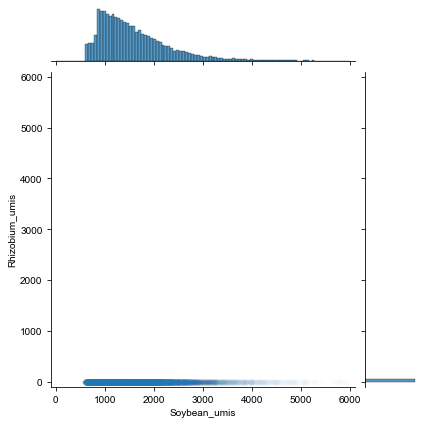

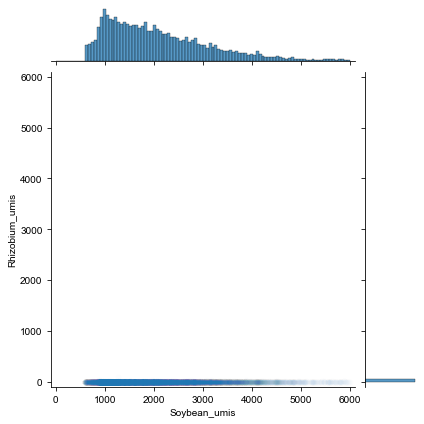

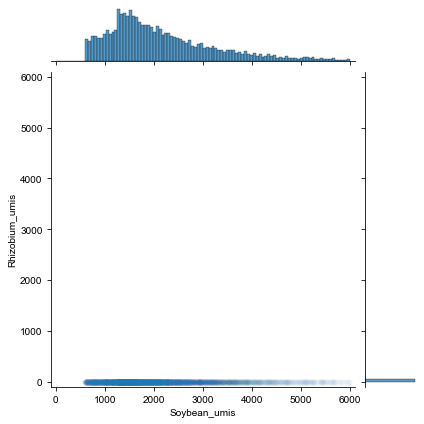

In [ ]:
for batch, _df in ad_rhi.obs.groupby('batch'):

    sns.jointplot(
        data=_df, x='Soybean_umis', y='Rhizobium_umis', xlim=(-100, 6100), ylim=(-100, 6100), 
        marginal_kws=dict(bins=np.linspace(0, 6000, 101)),
        joint_kws=dict(alpha=0.01)
    )
    plt.show()

In [ ]:
def addDensityToDf(df:pd.DataFrame, x:str, y:str, group=None, bins=20):
    from scipy.interpolate import interpn
    from scipy.stats import gaussian_kde

    if group:
        df = df.groupby(group, as_index=False).apply(lambda df: addDensityToDf(df, x=x, y=y, bins=bins)).reset_index(level=0, drop=True)
    elif bins is None:
        x = df[x].values
        y = df[y].values
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        df['temp_density'] = z
        df = df.sort_values('temp_density')
    else:
        x = df[x].values
        y = df[y].values
        data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
        z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)
        z[np.where(np.isnan(z))] = 0.0
        df['temp_density'] = z
        df = df.sort_values('temp_density')
    return df

In [ ]:
df = addDensityToDf(ad_rhi.obs.eval("Soybean_umis = Soybean_umis \n Rhizobium_umis = Rhizobium_umis"), x='Soybean_umis', y='Rhizobium_umis', group='batch', bins=None)
_dt = {'nodule_large': "Nodule (21 dpi)", "nodule_small": "Nodule (7 dpi)", "root": "Root"}

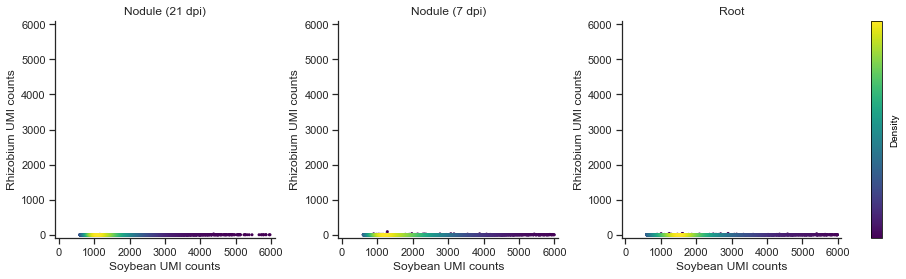

<Figure size 432x288 with 0 Axes>

In [ ]:
fig = plt.Figure(figsize=(12, 4))
ls_subfig = fig.subfigures(1, 4, width_ratios=(1,1,1,0.05))
for (batch, _df), subfig in zip(df.groupby('batch'), ls_subfig):
    (
        so.Plot(_df, x='Soybean_umis', y='Rhizobium_umis', color='temp_density')
        .add(so.Dot(fill=True, edgewidth=0, pointsize=3, alpha=1), legend=False)
        .scale(color='viridis')
        # .scale(y='log', x='log', color='viridis')
        .limit(x=(-100,6100), y=(-100,6100))
        .layout(size=(5,4))
        .label(title=_dt[batch], x='Soybean UMI counts', y='Rhizobium UMI counts')
        .theme(dt_snsStyle)
        .on(subfig).plot()
    )

from matplotlib.colors import Normalize
from matplotlib import cm

ax = ls_subfig[-1].add_subplot(111)
norm = Normalize(vmin = np.min(_df['temp_density']), vmax = np.max(_df['temp_density']))
cbar = ls_subfig[-1].colorbar(cm.ScalarMappable(norm = norm), cax=ax)
cbar.set_ticks([])
cbar.ax.set_ylabel('Density')
plt.tight_layout()
fig

# merge nodule and root steles

In [ ]:
df_araMarker = pd.read_table("/data/Zhaijx/liuzj/projects/singleCell/soybean/01_data/benfey.marker.csv")
df_araMarkerNoStage = pd.read_table("/data/Zhaijx/liuzj/projects/singleCell/soybean/01_data/benfey.marker.without.stage.csv")

dt_arab2soybean = pd.read_table(
    "/public/home/liuzj/data/ortholog/plant/parsed/1v1/arab__v__soybase_2.1v1.tsv"
).set_index("arab")["soybase_2"].to_dict()

In [ ]:
dt_araMarkerOth = (
    df_araMarker.eval("soybean_gene = gene.map(@dt_arab2soybean)").query("soybean_gene in @ad.var.index")
    .dropna(subset=["soybean_gene"]).groupby('cell type + dev stage group')['soybean_gene']
    .apply(lambda x: x.tolist()).to_dict()
)

In [ ]:
dt_araMarkerOthNoStage = (
    df_araMarkerNoStage.eval("soybean_gene = gene.map(@dt_arab2soybean)").query("soybean_gene in @ad.var.index")
    .dropna(subset=["soybean_gene"]).groupby('cell type group')['soybean_gene']
    .apply(lambda x: x.tolist()).to_dict()
)

In [ ]:
singleCellTools.geneEnrichInfo.getAUCellScore(ad, dt_araMarkerOthNoStage, layer='raw', threads=12, label='araMarkerOrthlogNoStage_auc')

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [ ]:
singleCellTools.geneEnrichInfo.getAUCellScore(ad, dt_araMarkerOth, layer='raw', threads=12, label='araMarkerOrthlog_auc')

Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [ ]:
_ad = singleCellTools.plotting.obsmToObs(ad, 'araMarkerOrthlog_auc')
sc.pl.umap(_ad, color=_ad.uns['plot_obsm'], cmap='Reds')

In [ ]:
ad_stele = ad[ad.obs.eval("Cluster in ['3', '9']")]

In [ ]:
_ad = singleCellTools.plotting.obsmToObs(ad_stele, 'araMarkerOrthlog_auc')
sc.pl.umap(_ad, color=_ad.uns['plot_obsm'], cmap='Reds', ncols=6)

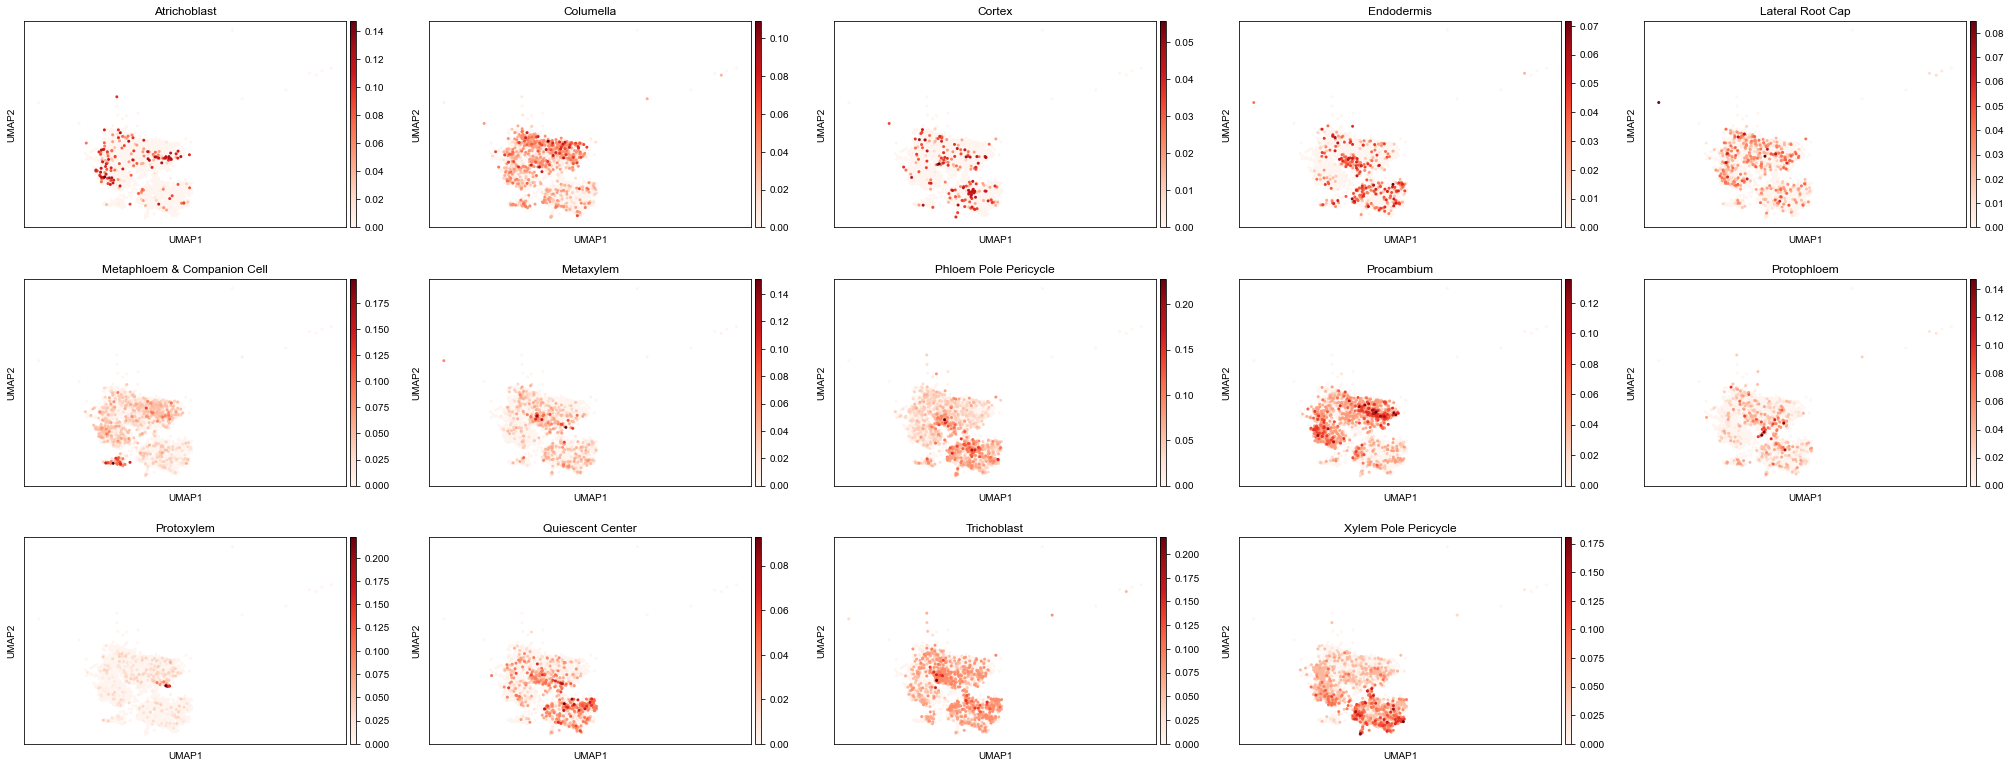

In [ ]:
_ad = singleCellTools.plotting.obsmToObs(ad_stele, 'araMarkerOrthlogNoStage_auc')
sc.pl.umap(_ad, color=_ad.uns['plot_obsm'], cmap='Reds', ncols=5)

# scANVI

In [ ]:
import scvi

In [ ]:
ad_ara = sc.read_h5ad('/data/Zhaijx/qinyw/data/flsnRNA/GSE152766_Root/GSE152766_Root_Atlas.h5ad')

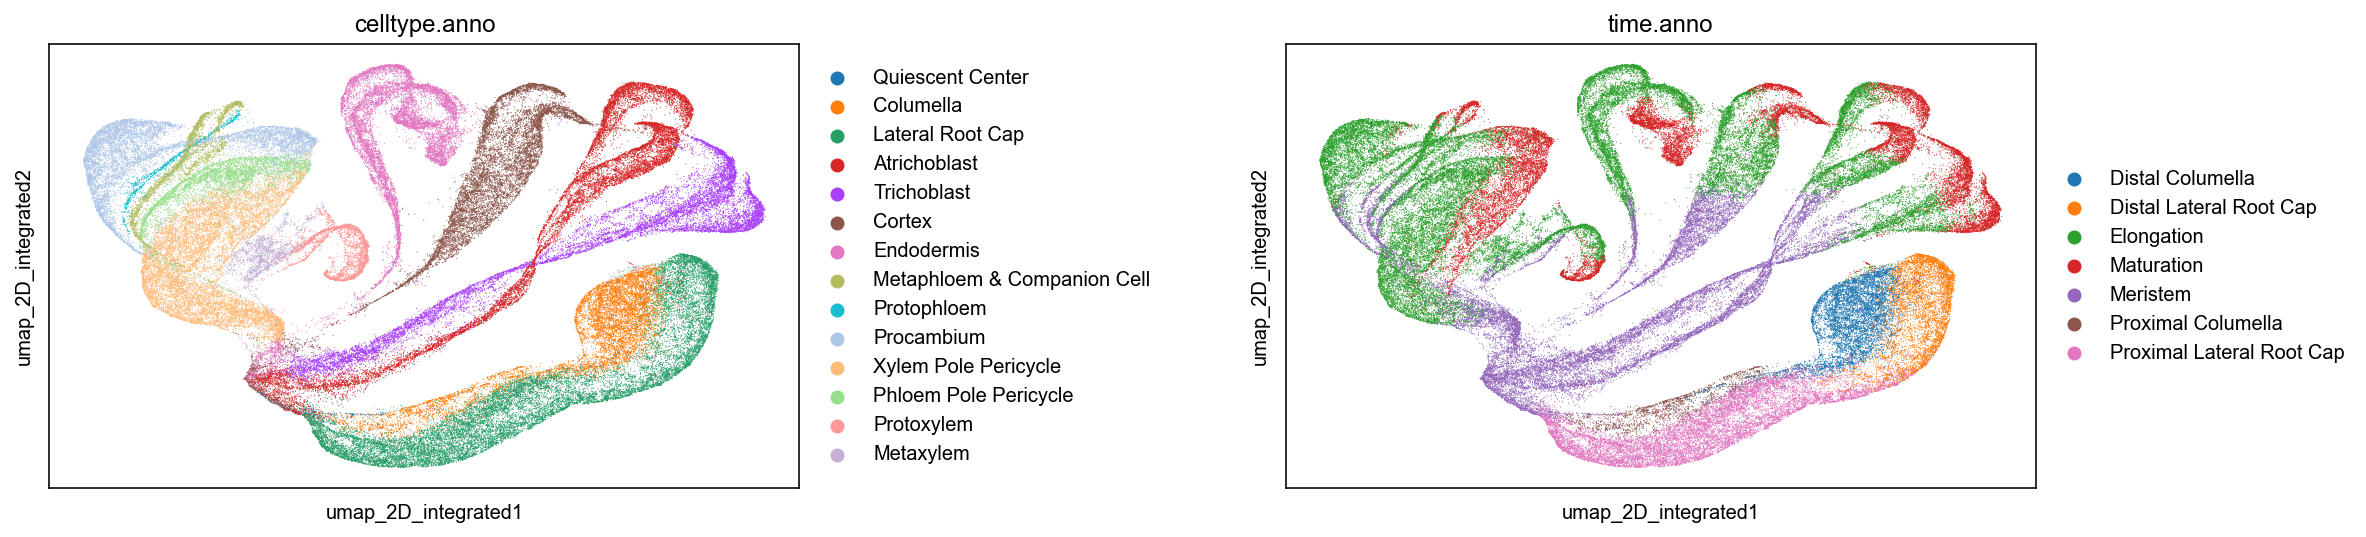

In [ ]:
sc.pl.embedding(ad_ara, 'umap_2D_integrated', color=['celltype.anno', 'time.anno'], wspace=0.5)

In [ ]:
singleCellTools.basic.initLayer(ad_ara, layer='RNA_counts')

In [ ]:
ad_ara = ad_ara[:, ad_ara.var.index.isin(list(dt_arab2soybean.keys()))]
ad_ara.var.index = ad_ara.var.index.map(dt_arab2soybean)
ad_ara.obs['specie'] = 'arabidopsis'

In [ ]:
ad_araSteleMature = ad_ara[ad_ara.obs.eval(
    "`celltype.anno` in ['Metaphloem & Companion Cell', 'Protophloem', 'Procambium', 'Xylem Pole Pericycle', 'Phloem Pole Pericycle', 'Protoxylem', 'Metaxylem'] & `time.anno` in ['Maturation']"
    )]

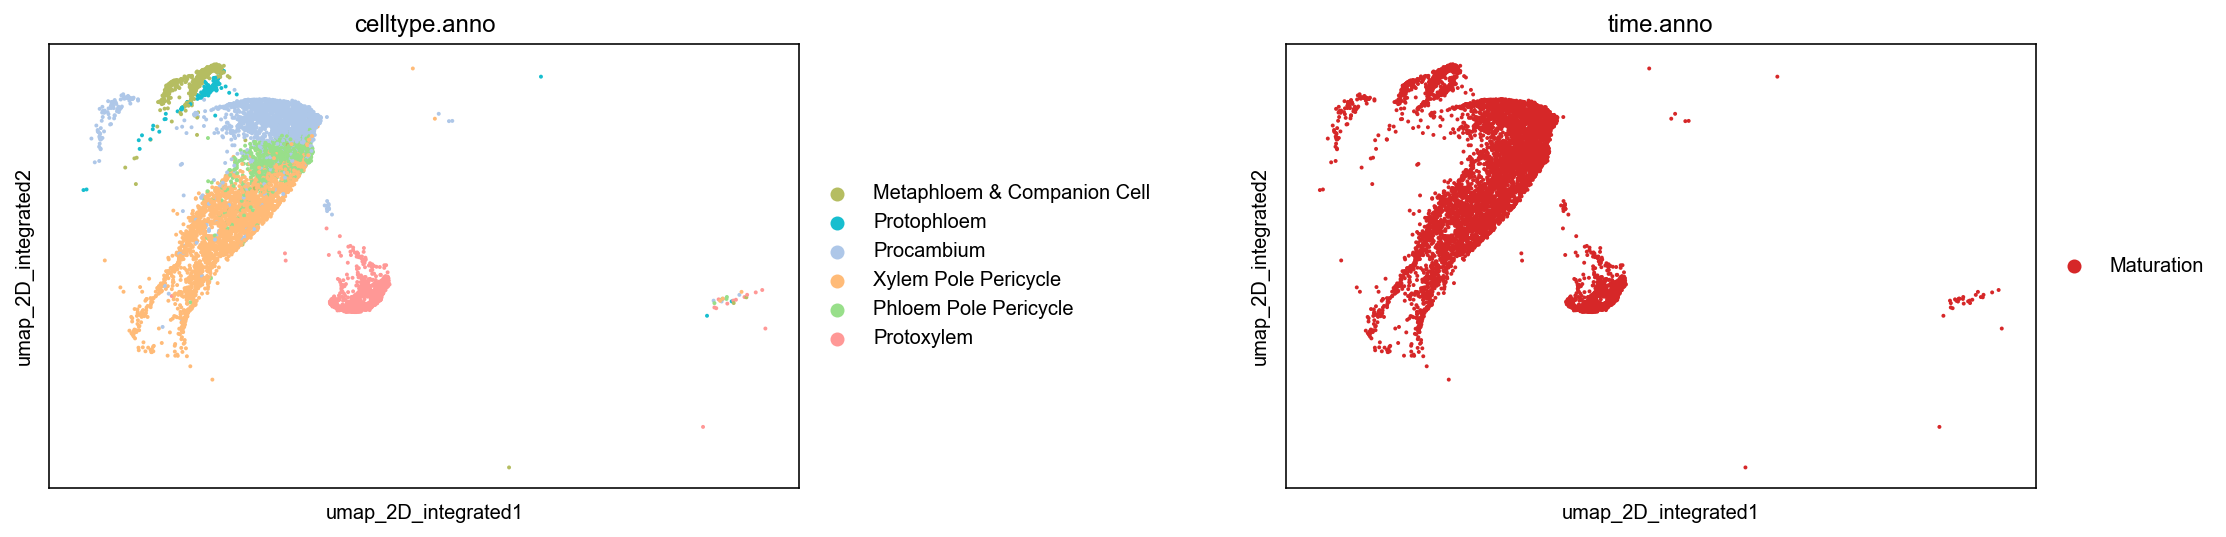

In [ ]:
sc.pl.embedding(ad_araSteleMature, 'umap_2D_integrated', color=['celltype.anno', 'time.anno'], wspace=0.5)

In [ ]:
toPkl(ad_stele, 'ad_stele', 'scem')
toPkl(ad_araSteleMature, 'ad_araSteleMature', 'scem')

2022-11-02 19:44:36.388 | INFO     | jpy_tools.otherTools:toPkl:477 - please run `loadPkl('ad_stele', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object
2022-11-02 19:45:23.698 | INFO     | jpy_tools.otherTools:toPkl:477 - please run `loadPkl('ad_araSteleMature', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


0
0


In [ ]:
# On SCEM

# ad_araSteleMature = loadPkl('ad_araSteleMature', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')
# ad_stele = loadPkl('ad_stele', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')
# ad_araSteleMature.obs['batch'] = 'root'
# ad_stele.obs['orig.ident'] = 'soybean_' + ad_stele.obs['batch'].astype(str)
# ad_stele.obs['specie'] = 'soybean'

# ad_steleScanviMerged = singleCellTools.annotation.labelTransferByScanvi(
#     ad_araSteleMature, 'celltype.anno', 'raw', ad_stele, 'raw', ls_removeCateKey=["orig.ident", "specie", "batch"], mode="merge", 
#     batch_size_ref=2**8,
#     batch_size_query=2**8,
#     dt_params2SCVIModel = {'n_layers': 5},
#     dt_params2SCANVIModel = {'n_layers':5},
#     n_top_genes=3000, needLoc=True,
#     hvgBatch='specie')

# toPkl(ad_steleScanviMerged, 'ad_steleScanviMerged', 'ipf')
# toPkl(ad_stele, 'ad_stele', 'ipf')

In [ ]:
ad_steleScanviMerged = loadPkl('ad_steleScanviMerged', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')
ad_stele = loadPkl('ad_stele', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')

In [ ]:
_ls_order =  [ 'Procambium', 'Protophloem', 'Protoxylem', 'Metaphloem & companion cell', 'Phloem pole pericycle','Xylem pole pericycle', 'Unknown']

In [ ]:
ad_stele.obs['labelTransfer_scanvi_celltype.anno'] = ad_stele.obs['labelTransfer_scanvi_celltype.anno'].str.capitalize().astype('category').cat.set_categories(_ls_order)
ad_steleScanviMerged.obs['labelTransfer_scanvi_celltype.anno'] = ad_steleScanviMerged.obs['labelTransfer_scanvi_celltype.anno'].str.capitalize().astype('category').cat.set_categories(_ls_order)

In [ ]:
def replaceSteleLabel(line):
    if line.name in ad_stele.obs.index:
        return ad_stele.obs.loc[line.name, 'labelTransfer_scanvi_celltype.anno']
    else:
        return line.loc['labelTransfer_scanvi_celltype.anno']
ad_steleScanviMerged.obs['labelTransfer_scanvi_celltype.anno'] = ad_steleScanviMerged.obs.apply(replaceSteleLabel, axis=1).astype('category').cat.set_categories(_ls_order)

In [ ]:
ad_steleScanviMerged.uns['labelTransfer_scanvi_celltype.anno_colors'][-1] = '#7F7F7F'

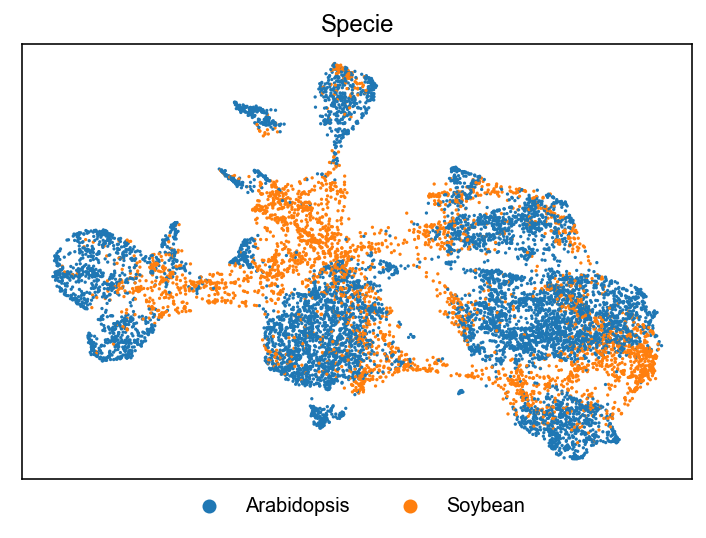

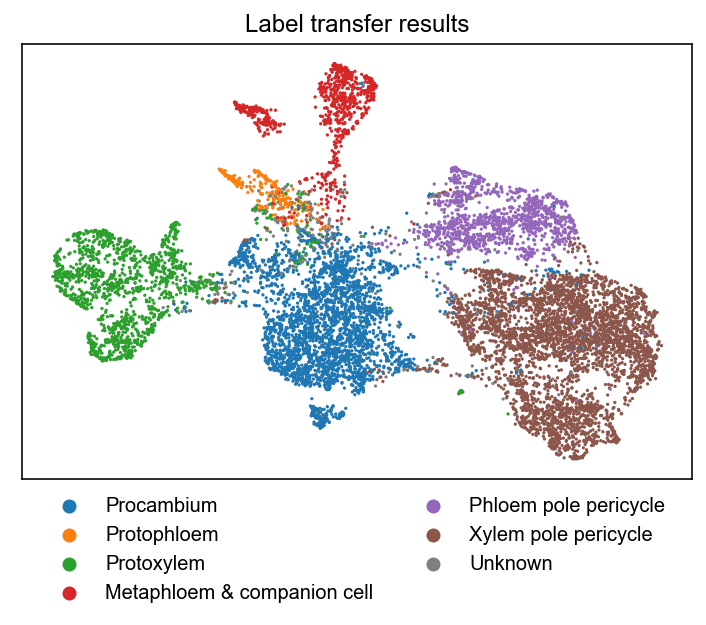

In [ ]:
ax = sc.pl.umap(ad_steleScanviMerged, color='specie', show=False, title='Specie')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ['Arabidopsis', 'Soybean'], loc='upper center', bbox_to_anchor=(0.5, 0), frameon=False, ncol=2)
plt.xlabel('')
plt.ylabel('')
plt.show()

ax = sc.pl.umap(ad_steleScanviMerged, color='labelTransfer_scanvi_celltype.anno', show=False, title='Label transfer results')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), frameon=False, ncol=2)
plt.xlabel('')
plt.ylabel('')
plt.show()


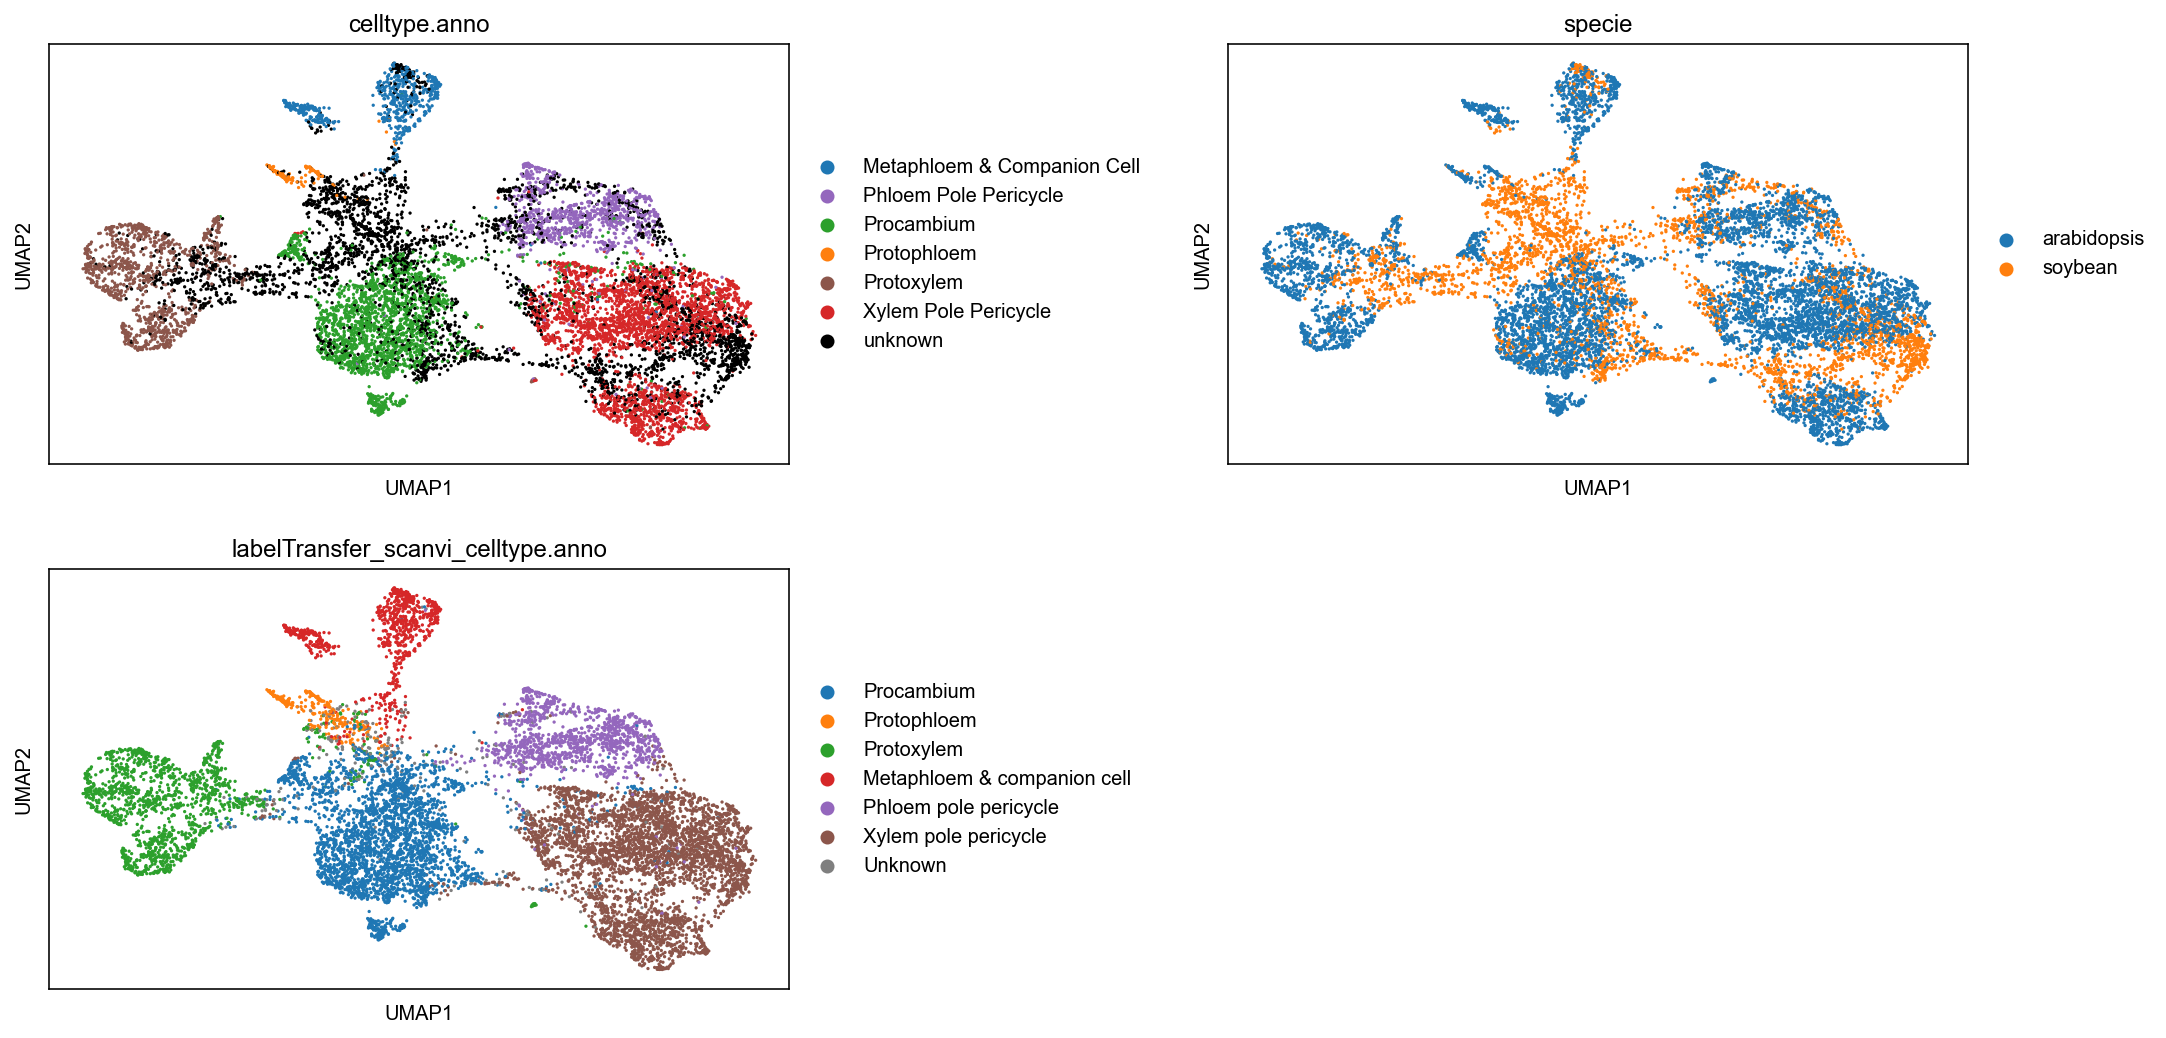

In [ ]:
sc.pl.umap(ad_steleScanviMerged, color=['celltype.anno', 'specie', 'labelTransfer_scanvi_celltype.anno'], wspace=0.45, ncols=2)

In [ ]:
ad_stele.uns['labelTransfer_scanvi_celltype.anno_colors'] =  ad_steleScanviMerged.uns['labelTransfer_scanvi_celltype.anno_colors']

In [ ]:
ad_stele.obsm['X_scANVI'] = ad_steleScanviMerged[ad_stele.obs.index].obsm['X_scANVI']
sc.pp.neighbors(ad_stele, 5, use_rep='X_scANVI')
sc.tl.umap(ad_stele, 0.3)


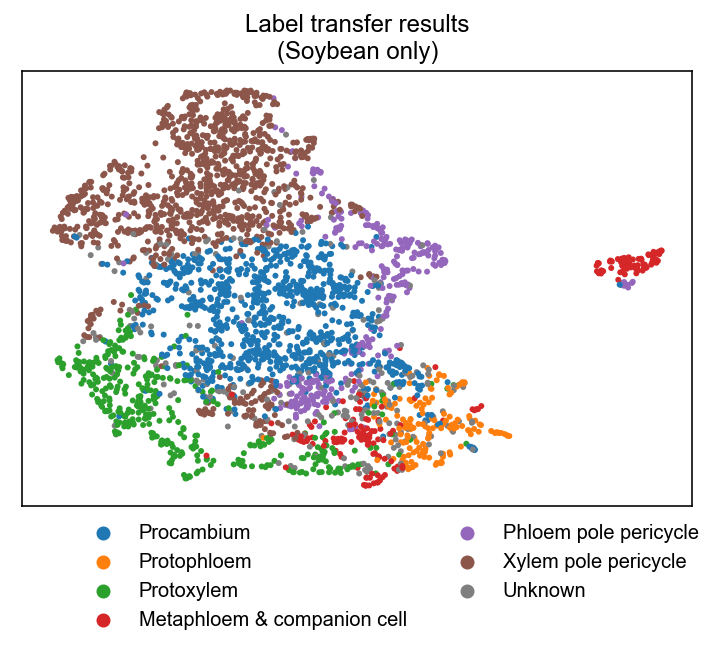

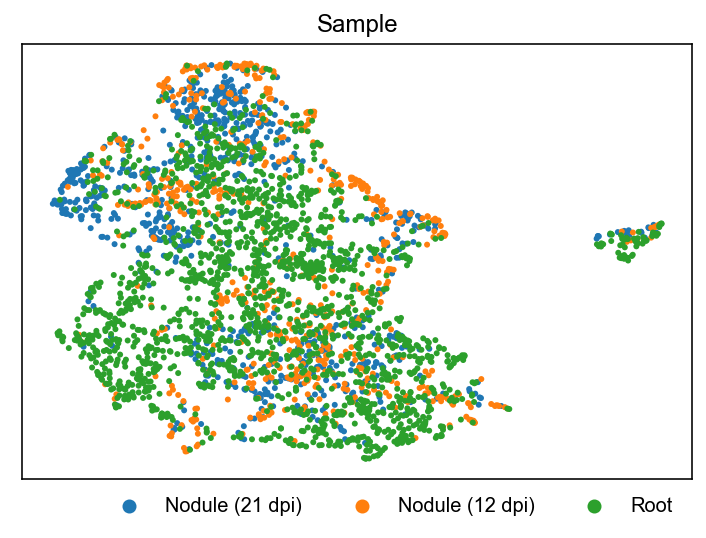

In [ ]:
ax = sc.pl.umap(ad_stele, color='labelTransfer_scanvi_celltype.anno', show=False, title="Label transfer results\n(Soybean only)")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), frameon=False, ncol=2)
plt.xlabel('')
plt.ylabel('')
plt.show()

ax = sc.pl.umap(ad_stele, color='Sample_time', show=False, title='Sample')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.55, 0), frameon=False, ncol=3)
plt.xlabel('')
plt.ylabel('')
plt.show()


In [ ]:
sc.tl.leiden(ad_stele, 0.2)

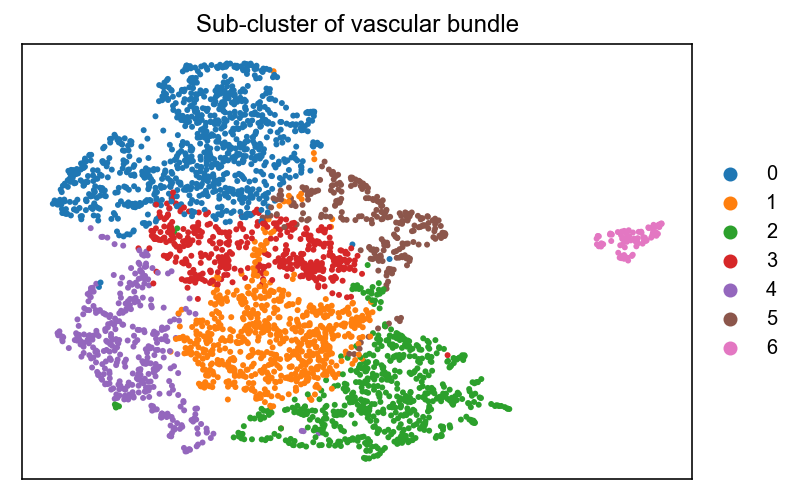

In [ ]:
sc.pl.umap(ad_stele, color='leiden', title="Sub-cluster of vascular bundle", show=False)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [ ]:
import matplotlib.legend as mlegend

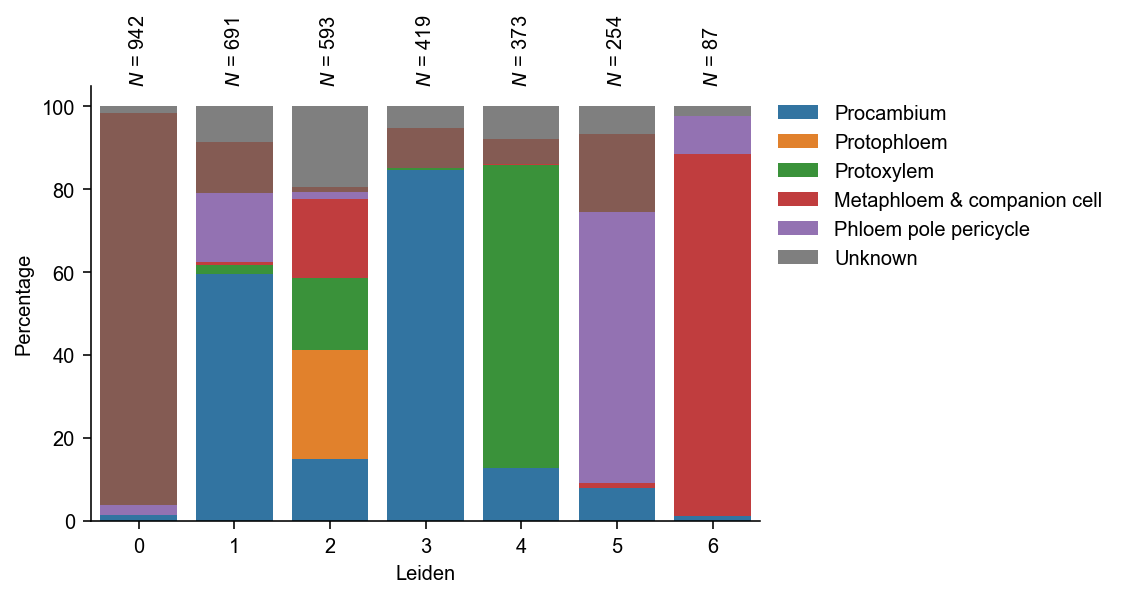

In [ ]:
singleCellTools.plotting.plotLabelPercentageInCluster(ad_stele, 'leiden', 'labelTransfer_scanvi_celltype.anno')
ax = plt.gca()
# remove Metaxylem due to the empty percentage and not present in mature roots
leg = ax.get_legend()
ls_handles = mlegend._get_legend_handles([ax]) >> F(list)
ls_labels = leg.get_texts() >> F(map, lambda x:x.get_text()) >> F(list)
ls_handles = ls_handles[-len(ls_labels):][::-1]
ls_handles.pop(5)
ls_labels.pop(5)
plt.legend(ls_handles, ls_labels, loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
plt.show()

In [ ]:
ad_stele.obsm['araMarkerOrthlogNoStage_auc'].columns = ad_stele.obsm['araMarkerOrthlogNoStage_auc'].columns >> F(map, str.lower) >> F(map, str.capitalize) >> F(list)

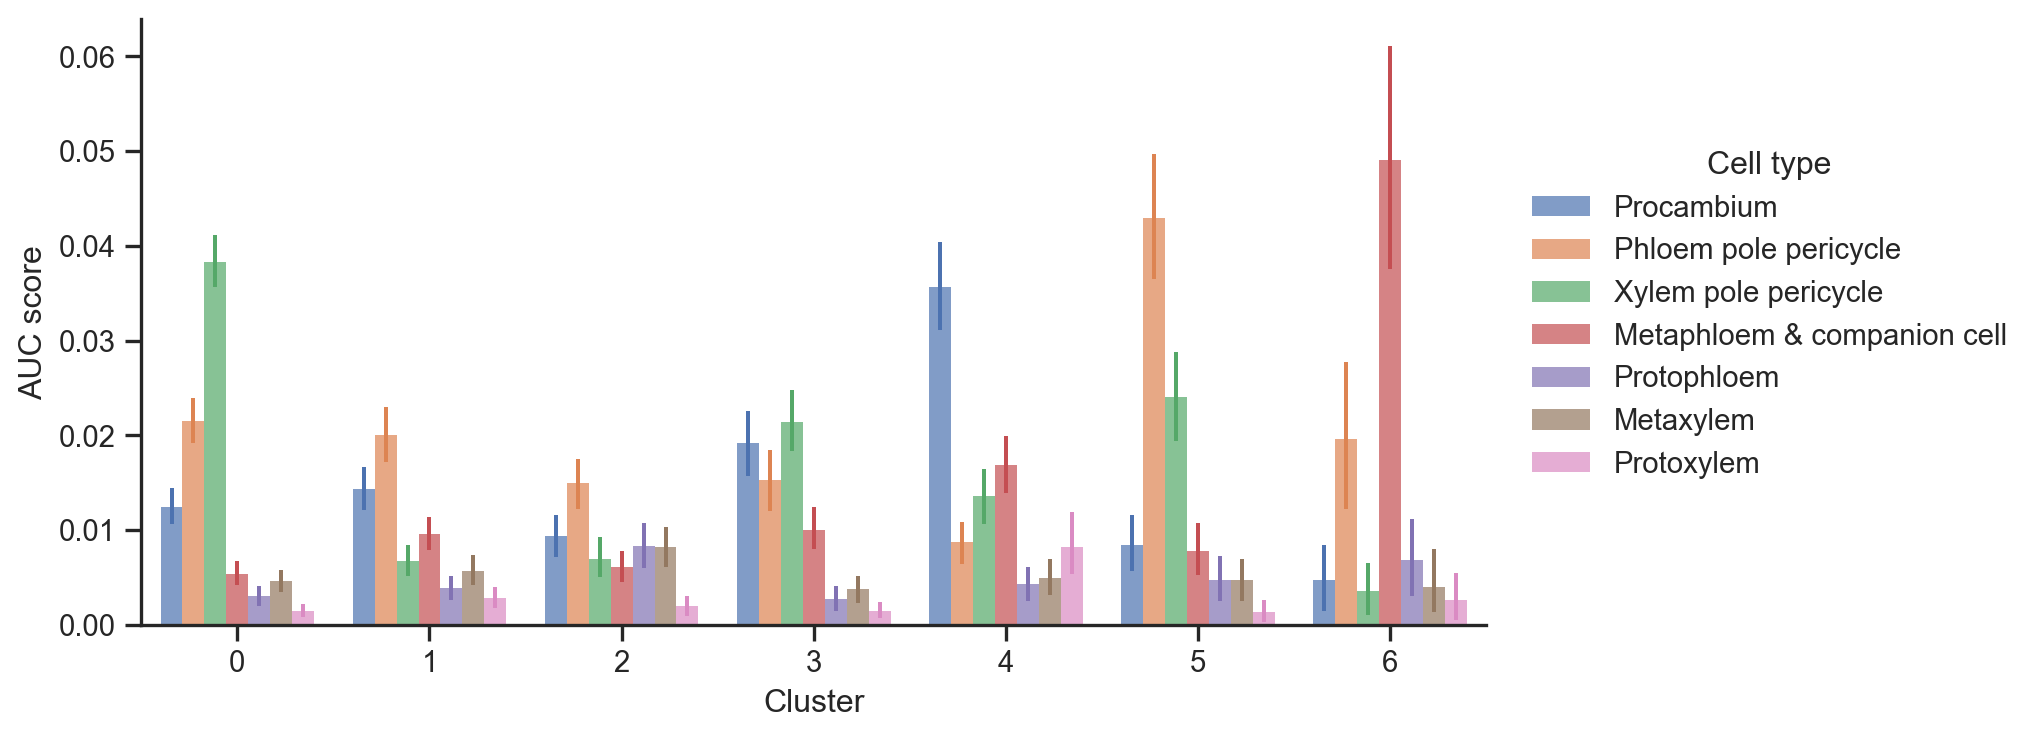

In [ ]:
(
    so.Plot(_df,  x='leiden', y='AUC score', color='Cell type')
    .add(so.Bar(edgewidth=0), so.Agg(), so.Dodge())
    .add(so.Range(), so.Est(errorbar=('ci', 99)), so.Dodge(), legend=False)
    .theme(dt_snsStyle)
    .label(x='Cluster')
    .layout(size=(8,4))
    .scale(color='deep')
)

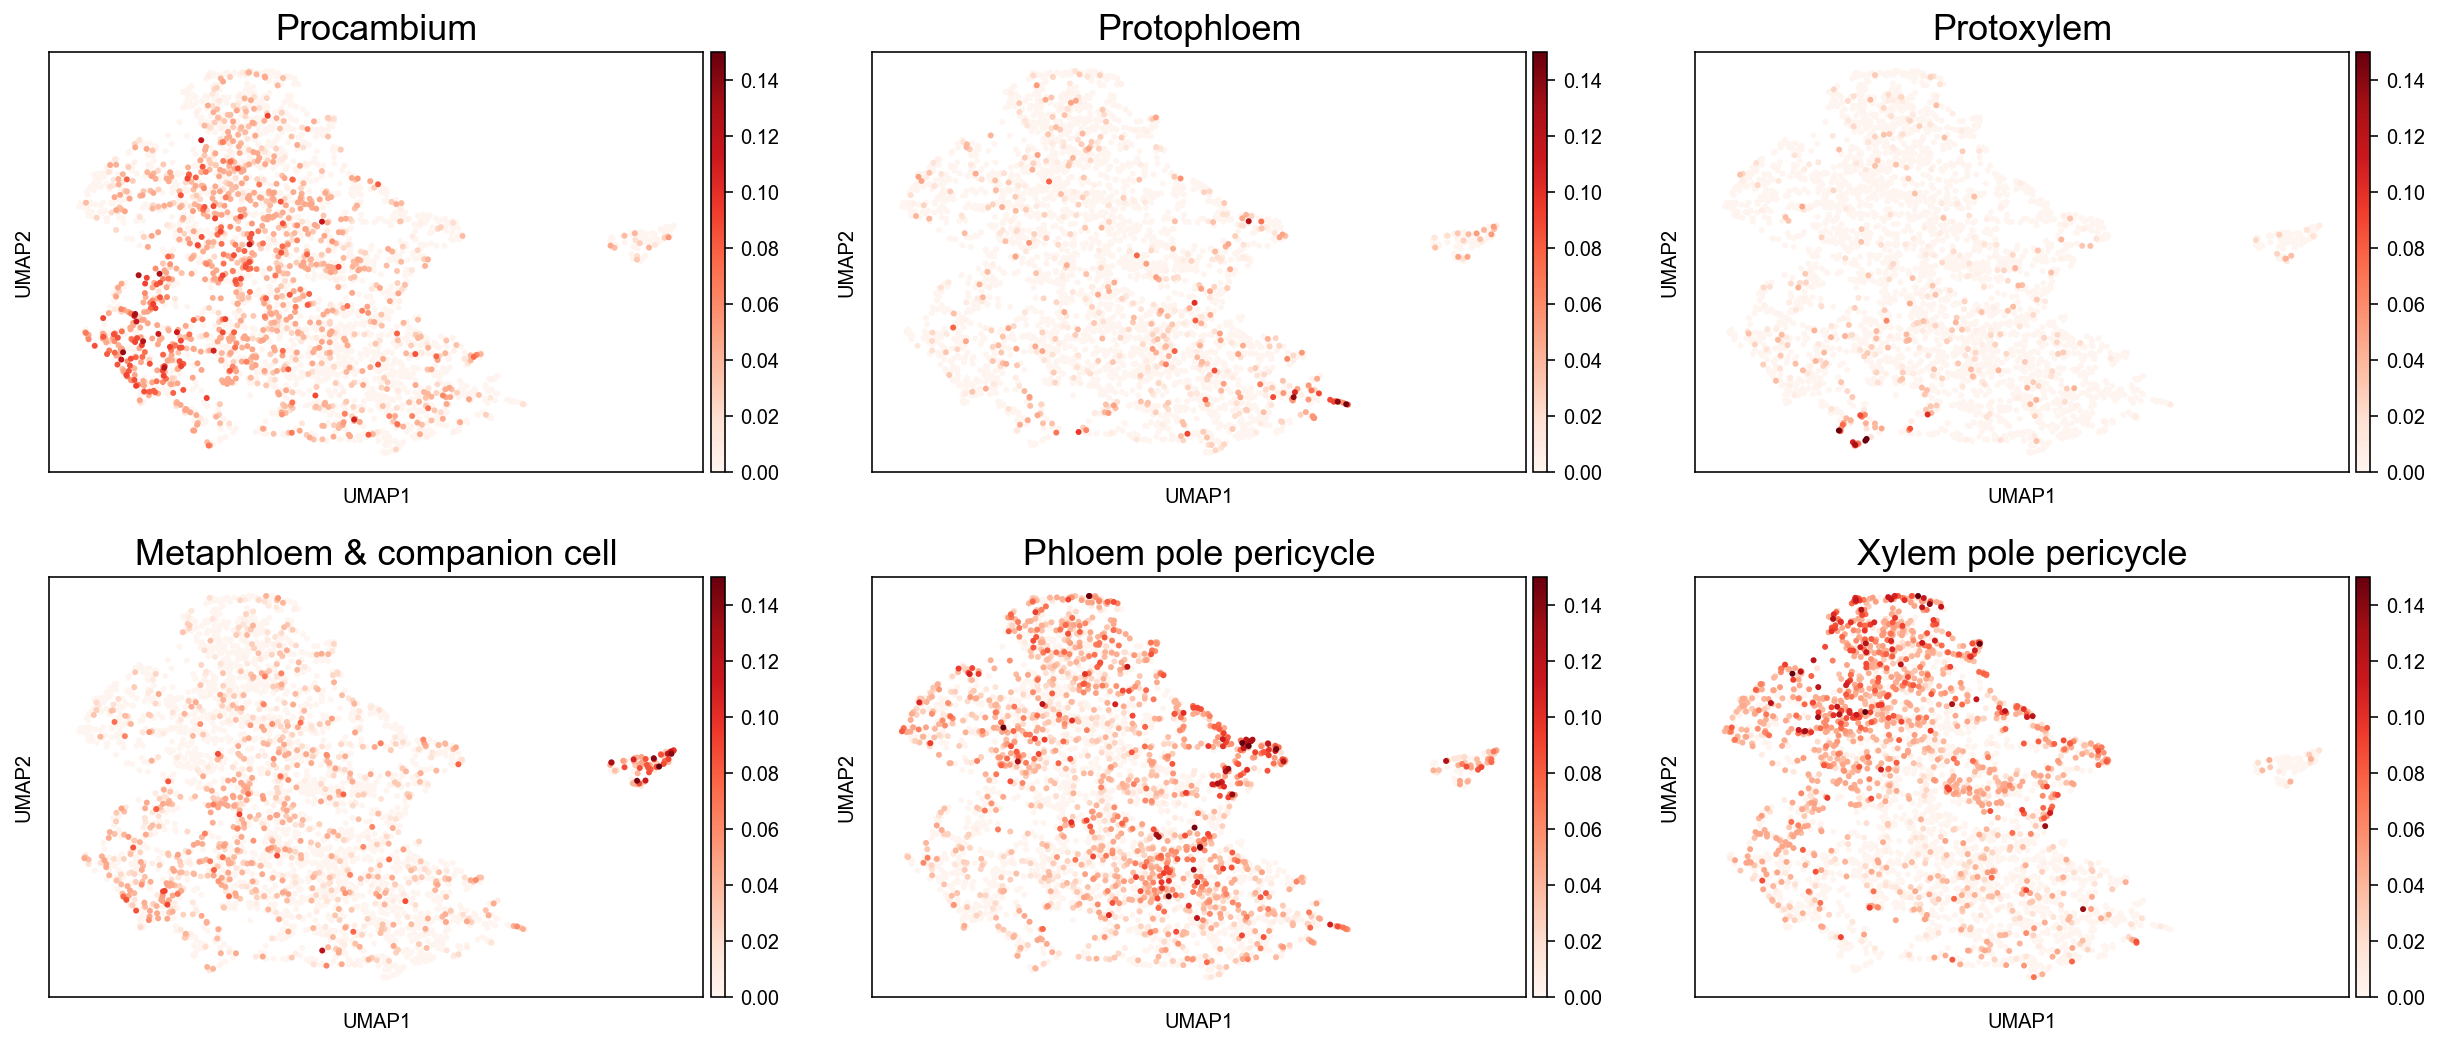

In [ ]:
_ad = singleCellTools.plotting.obsmToObs(ad_stele, 'araMarkerOrthlogNoStage_auc')
axs = sc.pl.umap(_ad, color=_ls_order[:-1], cmap='Reds', ncols=3, vmax=0.15, show=False)
for ax in axs:
    plt.sca(ax)
    plt.title(ax.get_title(), fontdict=dict(fontsize=18))

In [ ]:
dt_annoStele = {
    0:'Xylem pole pericycle', 1 : "Stele (Unknown)", 2: "Stele (Unknown, phloem like)", 3: "Stele (Unknown)", 4:"Stele (Unknown, xylem like)", 
    5: "Phloem pole pericycle", 6: "Metaphloem & companion cell"
}
dt_annoStele = {str(x): f"vb-{x}: {y}" for x,y in dt_annoStele.items()}

In [ ]:
ad_stele.obs['vb_ct'] = ad_stele.obs['leiden'].map(dt_annoStele)

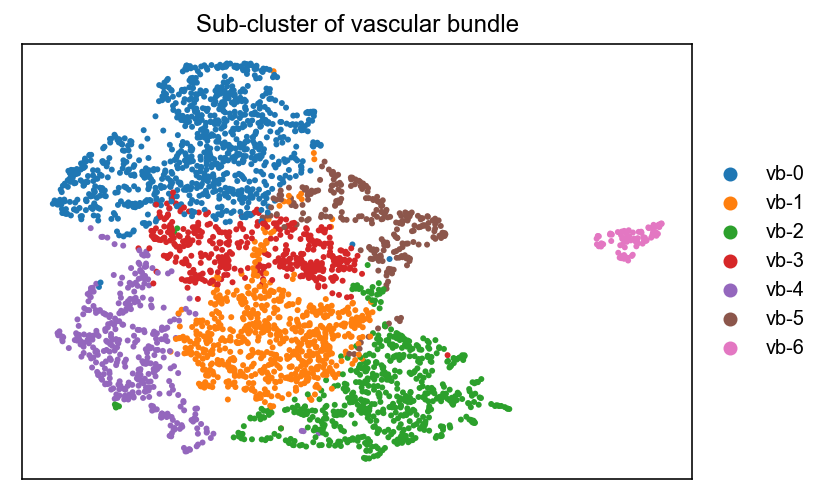

In [ ]:
ax = sc.pl.umap(ad_stele, color='leiden', wspace=0.2, show=False, title='Sub-cluster of vascular bundle')
handle, labels = ax.get_legend_handles_labels()
labels = [f"vb-{x}" for x in labels]
plt.xlabel('')
plt.ylabel('')
ax.legend(handle, labels, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, ncol=1)

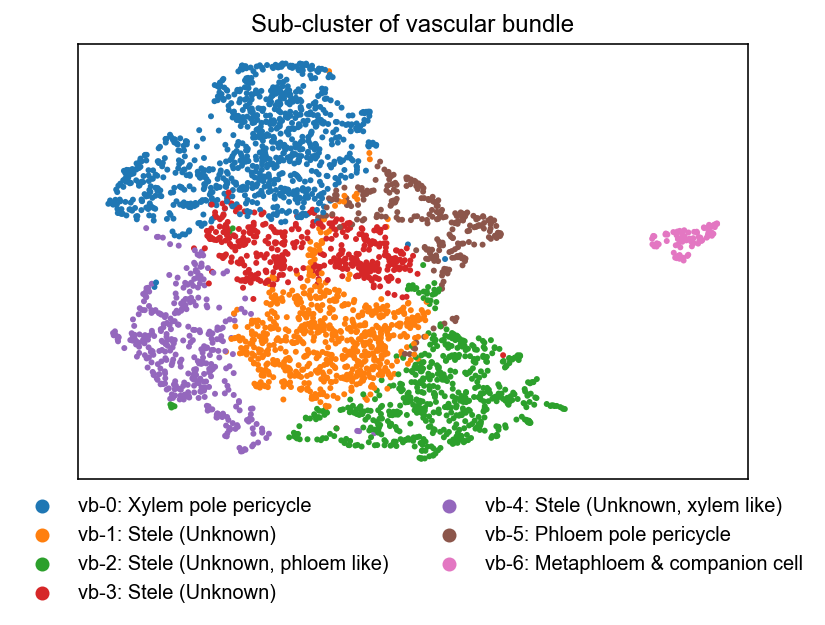

In [ ]:
ax = sc.pl.umap(ad_stele, color='vb_ct', wspace=0.2, show=False, title='Sub-cluster of vascular bundle')
handle, labels = ax.get_legend_handles_labels()
labels = [f"{x}" for x in labels]
plt.xlabel('')
plt.ylabel('')
ax.legend(handle, labels, loc='upper center', bbox_to_anchor=(0.5, 0), frameon=False, ncol=2)

In [ ]:
ad.obs['vb_ct'] = ad.obs['Cell type'].copy().astype(str)
ad.obs.loc[ad_stele.obs.index, 'vb_ct'] = ad_stele.obs['vb_ct'].astype(str)
ad.obs['vb_ct'] = ad.obs['vb_ct'].astype('category')

In [ ]:
singleCellTools.geneEnrichInfo.calculateEnrichScoreByCellex(ad, 'raw', 'vb_ct')

In [ ]:
df_steleSpecGeneAllCluster = ad.uns['vb_ct_cellexES'].query(
    "enrichScore > 0.75 & expressed_ratio > 0.1 & expressed_ratio / expressed_ratio_others > 2 & vb_ct.str.startswith('vb')"
)

In [ ]:
dt_steleSpecGeneAllCluster = df_steleSpecGeneAllCluster.groupby('vb_ct').apply(lambda df:df.nlargest(5, 'enrichScore')["gene"].to_list()).to_dict()

In [ ]:
ls_vbctOrder = [
    "0: Uninfected cells*",
    "1: Inner cortex",
    "2: Outer cortex*",
    "4: Outer cortex*",
    "5: Epidermis",
    "6: Unknown",
    "7: Uninfected cells*",
    "8: Endodermis",
    "10: Unknown",
    "11: Uninfected cells*",
    "12: Infected cells",
    "13: Unknown",
    "14: Unknown",
    "vb-0: Xylem pole pericycle",
    "vb-1: Stele (Unknown)",
    "vb-2: Stele (Unknown, phloem like)",
    "vb-3: Stele (Unknown)",
    "vb-4: Stele (Unknown, xylem like)",
    "vb-5: Phloem pole pericycle",
    "vb-6: Metaphloem & companion cell",
]
ad.obs['vb_ct'] = ad.obs['vb_ct'].cat.set_categories(ls_vbctOrder)

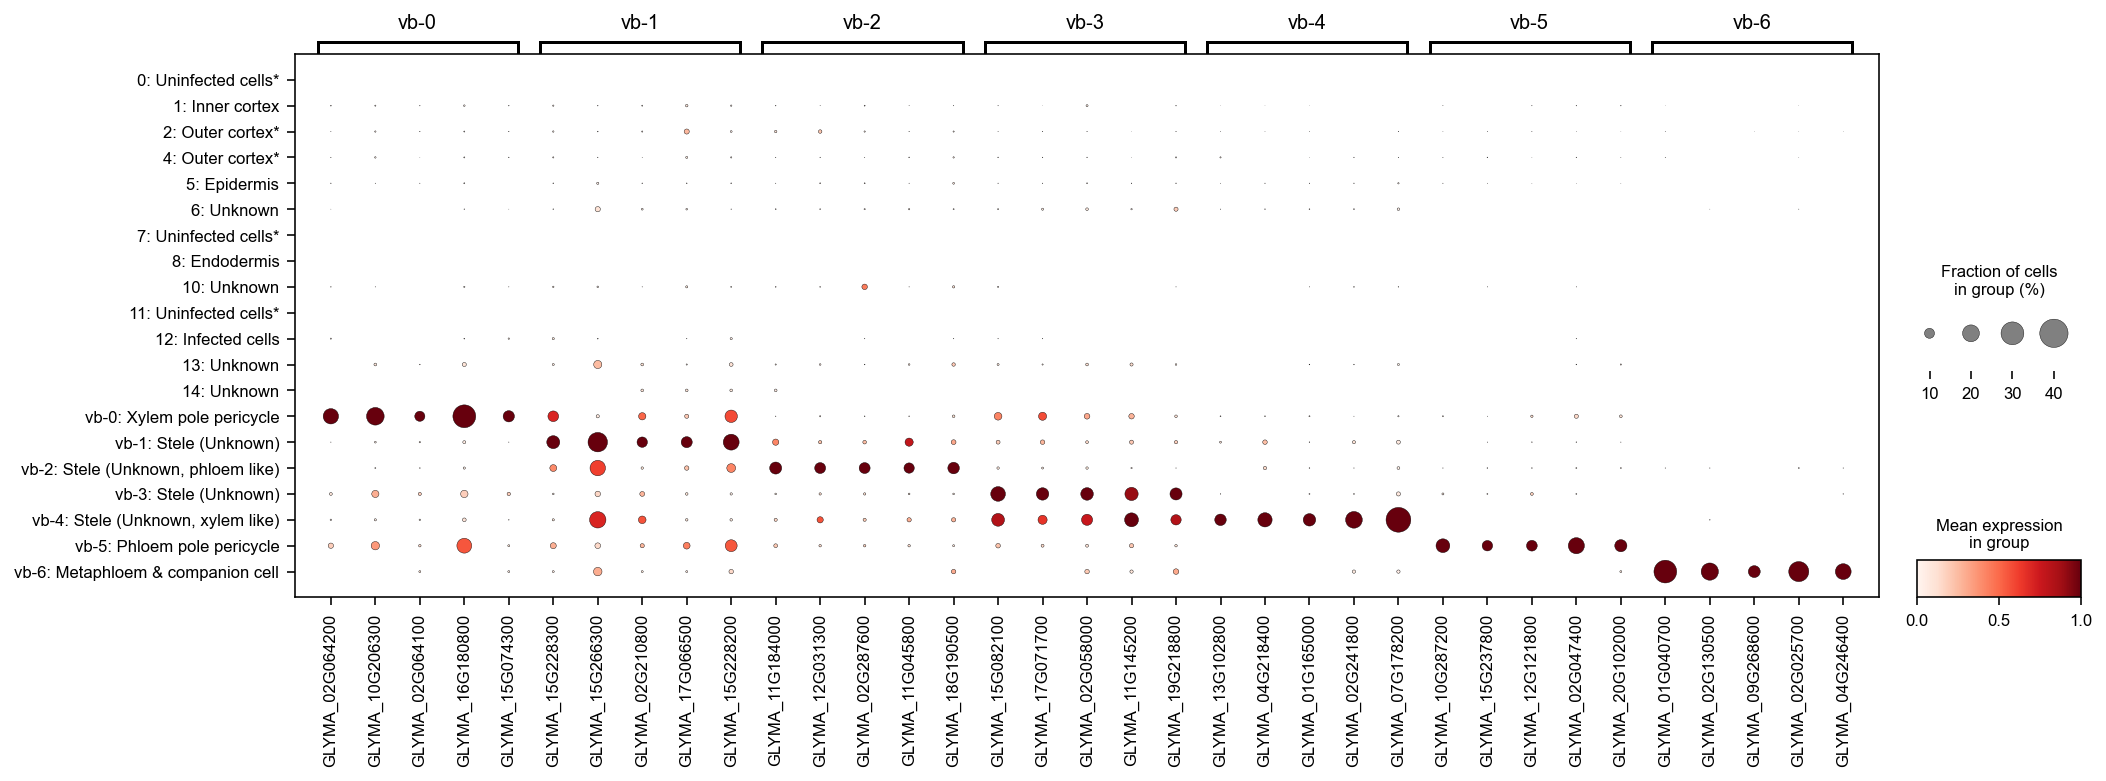

In [ ]:
sc.pl.dotplot(
    ad,
    {x.split(':')[0]: y for x, y in dt_steleSpecGeneAllCluster.items() if y if x.startswith('vb')},
    "vb_ct",
    layer="normalize_log",
    cmap="Reds",
    standard_scale='var',
    dot_max=0.4,
    figsize=(16, 5)
)

In [ ]:
df_steleSpecGeneAllCluster.to_excel(f"{dir_result}/vascular_bundle.xlsx")

In [ ]:
df_steleSpecGeneAllCluster.merge(df_symbol, how="left", left_on="gene", right_index=True).eval(
    "Symbol = Symbol.fillna('') \n other_designations = other_designations.fillna('')",
    engine="python",
).to_excel(f"{dir_result}/stele_spec_genes.xlsx")

# load gene dup list

In [ ]:
import glob
import re

In [ ]:
lsDf_geneDup = []
for f in glob.glob(f"/public/home/liuzj/projects/singleCell/soybean/01_data/pdgd/*.pairs"):
    df = pd.read_table(f, sep='\t')
    df['Category'] = re.search(r'Gma.(\w+).pairs', f).group(1)
    lsDf_geneDup.append(df)

In [ ]:
df_geneDup = pd.concat(lsDf_geneDup)

In [ ]:
df_geneDup.loc[lambda df:df['Category'] == 'transposed', 'Duplicate 1'] = df_geneDup.loc[lambda df:df['Category'] == 'transposed', 'Transposed']
df_geneDup.loc[lambda df:df['Category'] == 'transposed', 'Duplicate 2'] = df_geneDup.loc[lambda df:df['Category'] == 'transposed', 'Parental']

In [ ]:
df_geneDup['Gene 1'] = df_geneDup['Duplicate 1'].str.replace("Glyma.", "GLYMA_").str.split('.').str[0]
df_geneDup['Gene 2'] = df_geneDup['Duplicate 2'].str.replace("Glyma.", "GLYMA_").str.split('.').str[0]

In [ ]:
df_geneDup = df_geneDup.loc[lambda df: df.eval("`Gene 1` in @ad.var.index & `Gene 2` in @ad.var.index")]

In [ ]:
_ls = ['GLYMA_08G071200', 'GLYMA_13G043800']
df_geneDup.query("`Gene 1` in @_ls | `Gene 2` in @_ls")

Duplicate 1           Location        Duplicate 2  \
14311  Glyma.08G071200.1  Gma-Chr08:5438763  Glyma.13G043800.1   

               Location.1  E-value   Category Transposed Parental  \
14311  Gma-Chr13:13707907      0.0  dispersed        NaN      NaN   

                Gene 1           Gene 2  
14311  GLYMA_08G071200  GLYMA_13G043800

# Correlation

In [ ]:
ad_merged = singleCellTools.geneEnrichInfo._mergeData(ad, 'Cluster', layer='raw')

In [ ]:
singleCellTools.basic.initLayer(ad_merged, total=1e6)

In [ ]:
from scipy import stats

In [ ]:
def getSpearmanR(sr, ad, layer, gene2='Gene 2'):
    gene1 = sr.at['Gene 1']
    gene2 = sr.at[gene2]
    return stats.spearmanr(ad[:, gene1].layers[layer].reshape(-1), ad[:, gene2].layers[layer].reshape(-1))[0]

In [ ]:
df_geneDup['Gene Shuffle'] = df_geneDup['Gene 2'].sample(frac=1, random_state=39).values

In [ ]:
df_geneDup["SpearmanR"] = df_geneDup.apply(getSpearmanR, axis=1, ad=ad_merged, layer='normalize_log', gene2='Gene 2')

In [ ]:
df_geneDup["SpearmanR_Shuffle"] = df_geneDup.apply(getSpearmanR, axis=1, ad=ad_merged, layer='normalize_log', gene2='Gene Shuffle')

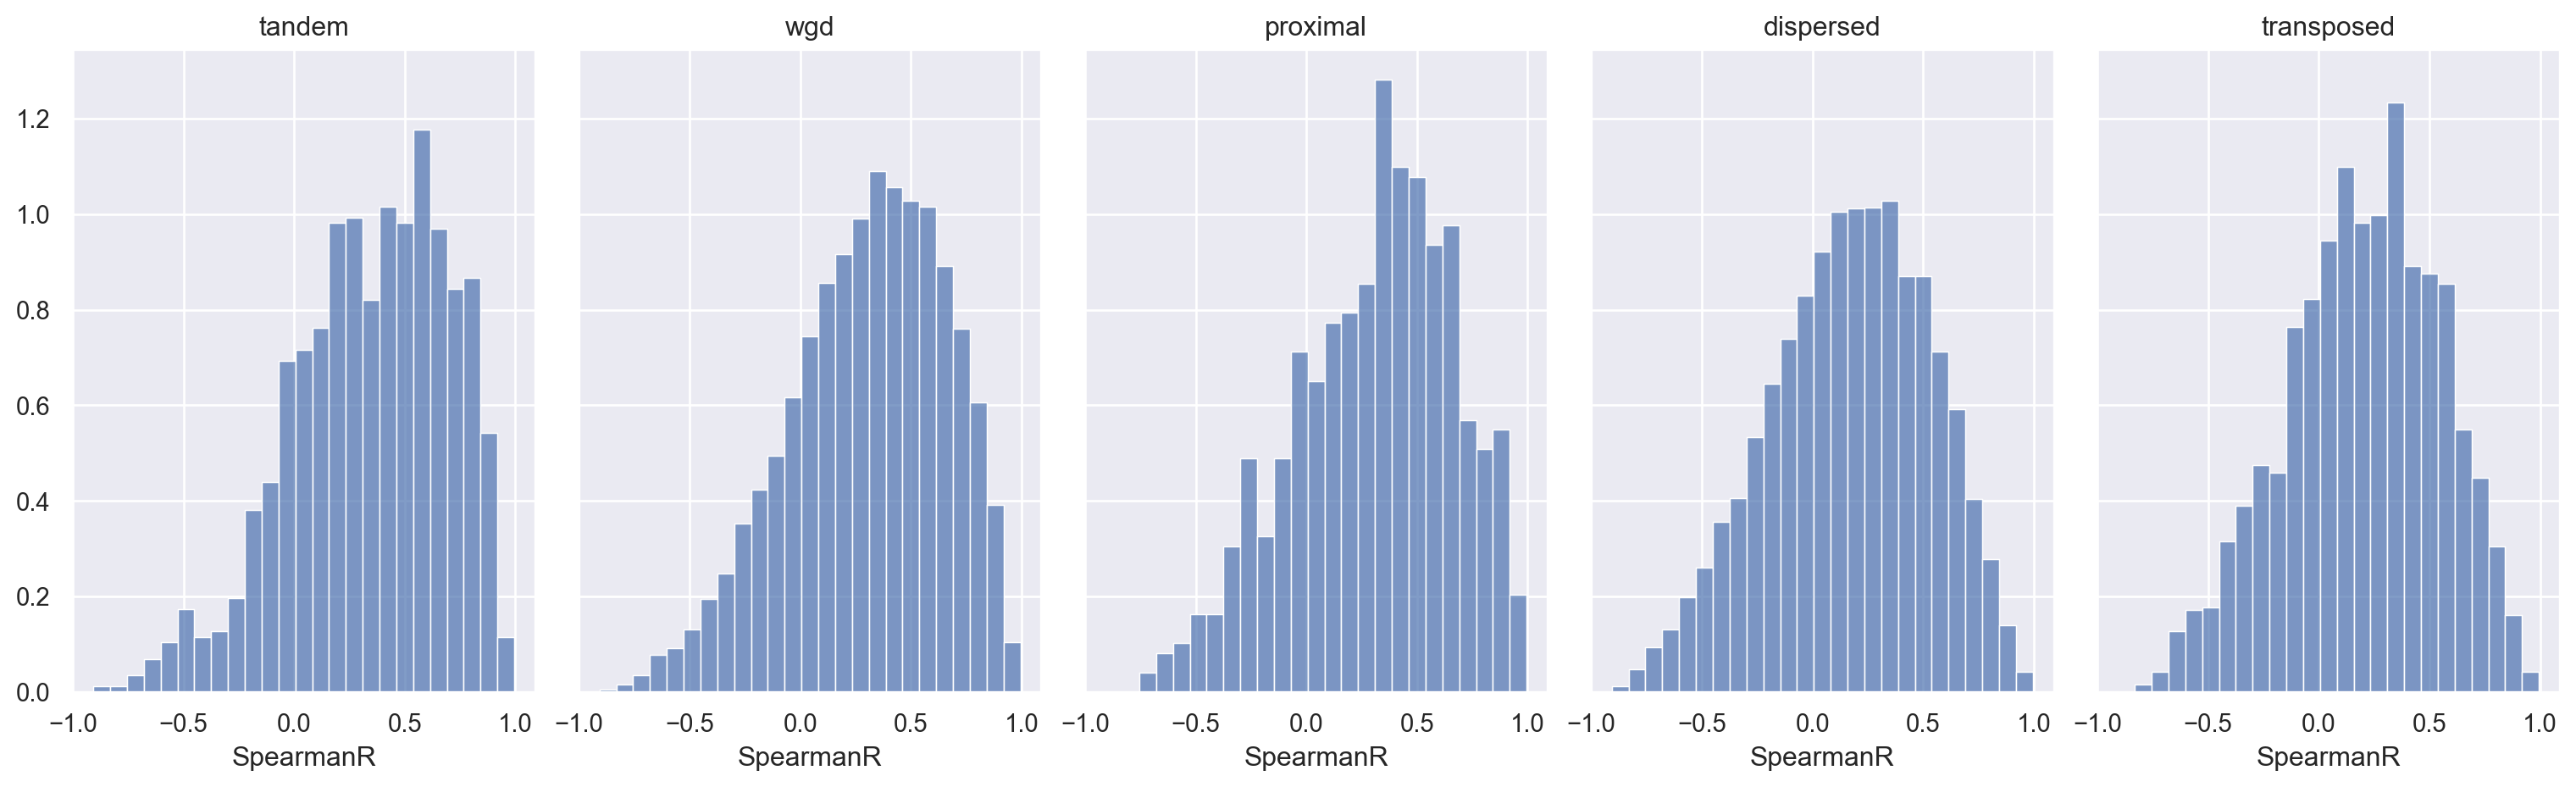

In [ ]:
(
    so.Plot(df_geneDup, x='SpearmanR')
    .facet(col='Category')
    .add(so.Bars(), so.Hist(stat='density', bins=25))
    .layout(size=(16,5))
)

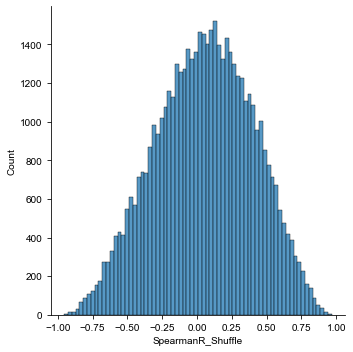

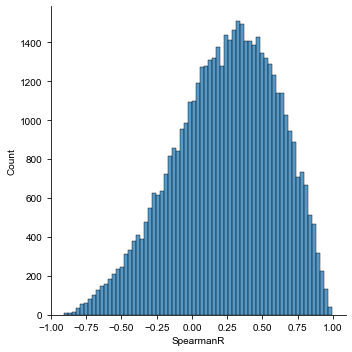

In [ ]:
sns.displot(df_geneDup['SpearmanR_Shuffle'])
sns.displot(df_geneDup['SpearmanR'])

## only 1-1 paralog

In [ ]:
import tqdm

In [ ]:
ls_paralogGroup = []

In [ ]:
df_geneDup = df_geneDup.drop_duplicates(['Gene 1', 'Gene 2'])

In [ ]:
ls_onePairOrth = pd.concat([df_geneDup['Gene 1'], df_geneDup['Gene 2']]).sort_values().value_counts().loc[lambda sr:sr == 1].index.to_list()

In [ ]:
df_paralog1v1Only = df_geneDup.query("`Gene 1` in @ls_onePairOrth & `Gene 2` in @ls_onePairOrth")[['Gene 1', 'Gene 2']].rename(columns={'Gene 1': 'G1', 'Gene 2': 'G2'})

In [ ]:
def getSpearmanR(sr, ad, layer, gene2='Gene 2'):
    gene1 = sr.at['G1']
    gene2 = sr.at[gene2]
    return stats.spearmanr(ad[:, gene1].layers[layer].reshape(-1), ad[:, gene2].layers[layer].reshape(-1))[0]

In [ ]:
df_paralog1v1Only["SpearmanR"] = df_paralog1v1Only.apply(getSpearmanR, axis=1, ad=ad_merged, layer='normalize_log', gene2='G2')

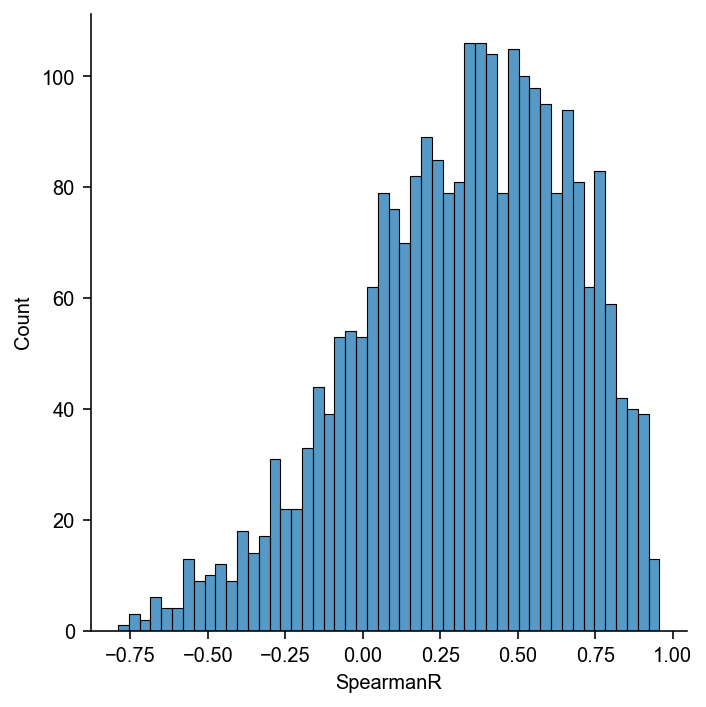

In [ ]:
sns.displot(df_paralog1v1Only['SpearmanR'], bins=50)

### compare with shuffled

In [ ]:
df_paralog1v1Only['Gene Shuffle'] = df_paralog1v1Only['G2'].sample(frac=1, random_state=39, replace=True).values

In [ ]:
df_paralog1v1Only["SpearmanR_shuffle"] = df_paralog1v1Only.apply(getSpearmanR, axis=1, ad=ad_merged, layer='normalize_log', gene2='Gene Shuffle')

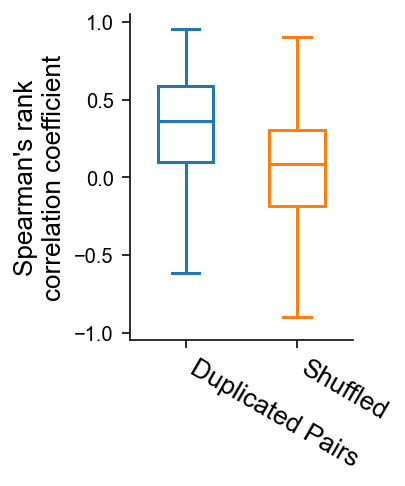

In [ ]:
import matplotlib as mpl
fig, ax = plt.subplots(figsize=(2,3))
ax = sns.boxplot(data = df_paralog1v1Only[['SpearmanR', 'SpearmanR_shuffle']].melt(), x='variable', y='value', ax=ax, fliersize=0, width=0.5)

for i, (box, color) in enumerate(zip([x for x in ax.get_children() if isinstance(x, mpl.patches.PathPatch)], sns.color_palette())):
    box.set_edgecolor(color)
    box.set_facecolor("white")
    # iterate over whiskers and median lines
    for j in range(6 * i, 6 * (i + 1)):
        ax.lines[j].set_color(color)
sns.despine()
plt.ylabel("Spearman's rank\ncorrelation coefficient", fontsize=13)
plt.xticks([0,1], ['Duplicated Pairs', 'Shuffled'], rotation=-30, ha='left', fontsize=13)
plt.xlabel('')

plt.show()

In [ ]:
import scipy.stats

In [ ]:
scipy.stats.ttest_ind(df_paralog1v1Only['SpearmanR'], df_paralog1v1Only['SpearmanR_shuffle']).pvalue

6.748250002626319e-150

### get p value (boot strap)

In [ ]:
from joblib import Parallel, delayed

In [ ]:
singleCellTools.geneEnrichInfo.getBgGene(ad, df_paralog1v1Only['G2'].to_list())

['GLYMA_16G180100',
 'GLYMA_03G029100',
 'GLYMA_15G276900',
 'GLYMA_08G286300',
 'GLYMA_08G204900',
 'GLYMA_01G044000',
 'GLYMA_10G046100',
 'GLYMA_18G226700',
 'GLYMA_02G082500',
 'GLYMA_01G184900',
 'ENSRNA050001470',
 'GLYMA_05G211000',
 'GLYMA_09G146000',
 'GLYMA_13G198100',
 'GLYMA_11G048800',
 'GLYMA_14G156800',
 'GLYMA_02G239000',
 'GLYMA_01G245000',
 'GLYMA_13G355700',
 'GLYMA_12G063300',
 'GLYMA_16G131700',
 'GLYMA_15G073800',
 'GLYMA_15G125600',
 'GLYMA_07G096300',
 'GLYMA_05G069300',
 'GLYMA_01G152200',
 'GLYMA_16G209700',
 'GLYMA_06G092600',
 'GLYMA_03G193200',
 'GLYMA_07G250300',
 'GLYMA_13G277300',
 'GLYMA_13G152800',
 'GLYMA_17G214500',
 'GLYMA_03G054100',
 'GLYMA_16G158800',
 'GLYMA_08G291200',
 'GLYMA_08G215900',
 'GLYMA_01G123100',
 'GLYMA_10G001800',
 'GLYMA_19G045900',
 'GLYMA_02G121800',
 'GLYMA_01G224500',
 'GLYMA_04G045200',
 'GLYMA_05G155900',
 'GLYMA_09G183000',
 'GLYMA_13G213500',
 'GLYMA_11G065300',
 'GLYMA_15G110400',
 'GLYMA_02G297100',
 'GLYMA_02G013900',


In [ ]:
for i in tqdm.tqdm(range(1000)):
    df_paralog1v1Only[f"seed_{i}_bg"] = singleCellTools.geneEnrichInfo.getBgGene(ad, df_paralog1v1Only['G2'].to_list(), seed=i, usePreBin='bins_ForPickMock')

100%|██████████| 1000/1000 [02:00<00:00,  8.33it/s]


In [ ]:
def getBootstrapPearson(df:pd.DataFrame, ad):
    ls_result = []
    for nt in df.itertuples():
        ls_oneLineResult = []
        g1 = nt.G1
        for i in range(1000):
            g2 = getattr(nt, f"seed_{i}_bg")
            g2_corr = stats.spearmanr(ad[:, g1].layers['normalize_log'].reshape(-1), ad[:, g2].layers['normalize_log'].reshape(-1))[0]
            ls_oneLineResult.append(g2_corr)
        ls_result.append(ls_oneLineResult)
    df_result = pd.DataFrame(ls_result, columns=[f"seed_{i}_corr" for i in range(1000)], index=df.index)
    df_result = pd.concat([df, df_result], axis=1)
    return df_result

In [ ]:
df_paralog1v1Only['joblib_group'] = np.random.random_integers(0, 63, size=len(df_paralog1v1Only))

In [ ]:
_lsDf = Parallel(64)(delayed(getBootstrapPearson)(x[1], ad_merged) for x in df_paralog1v1Only.groupby('joblib_group'))

In [ ]:
df_paralogBootstrapResult = pd.concat(_lsDf)

In [ ]:
df_paralogBootstrapResult = df_paralogBootstrapResult.reset_index(drop=True)

In [ ]:
df_paralogBootstrapResult['G2_rank'] = df_paralogBootstrapResult[['SpearmanR']].join(df_paralogBootstrapResult.filter(regex=r"seed_\d+_corr")).rank(1, method='first', ascending=False)['SpearmanR']

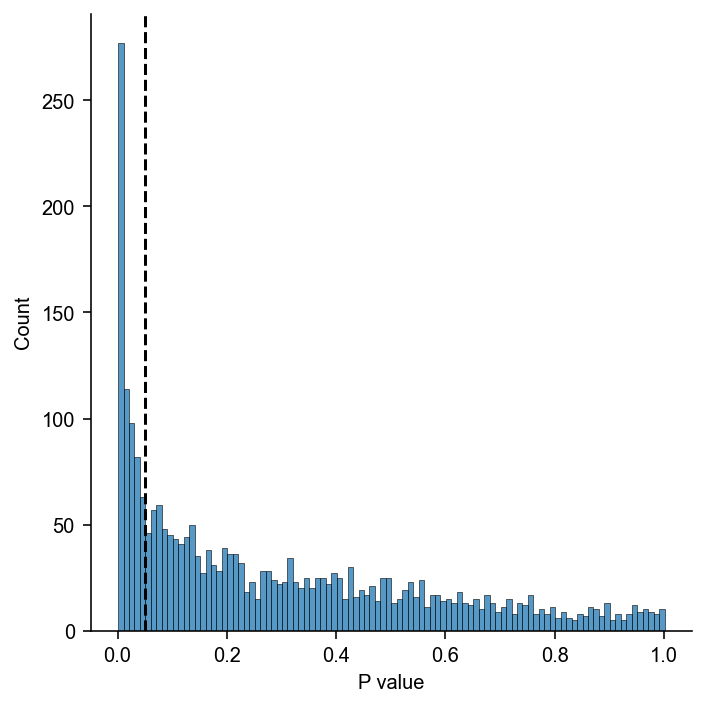

In [ ]:
sns.displot(df_paralogBootstrapResult['G2_rank'] / 1000, bins=100)
plt.xlabel('P value')
plt.axvline(x=0.05, ls='--', color='black')
plt.show()

In [ ]:
df_paralogBootstrapResult['G2_rank'] = df_paralogBootstrapResult[['SpearmanR']].join(df_paralogBootstrapResult.filter(regex=r"seed_\d+_corr")).rank(1, method='first', ascending=False)['SpearmanR']

In [ ]:
df_paralogBootstrapResult['p'] = df_paralogBootstrapResult['G2_rank'] / 1000

In [ ]:
df_paralogBootstrapResult.query("p < 0.05") 

G1               G2  SpearmanR        seed_0_bg  \
3     GLYMA_02G186700  GLYMA_10G106900   0.896429  GLYMA_11G192600   
5     GLYMA_02G284400  GLYMA_14G030600   0.732143  GLYMA_04G066300   
13    GLYMA_05G148900  GLYMA_08G105600   0.764969  GLYMA_13G358800   
16    GLYMA_07G180000  GLYMA_20G009200   0.750000  GLYMA_02G018200   
25    GLYMA_14G081100  GLYMA_17G244300   0.642857  GLYMA_07G196000   
...               ...              ...        ...              ...   
2534  GLYMA_01G064400  GLYMA_02G122200   0.796429  GLYMA_13G213500   
2541  GLYMA_04G252900  GLYMA_06G109600   0.867857  GLYMA_02G150100   
2552  GLYMA_09G264700  GLYMA_18G227200   0.714286  GLYMA_04G222800   
2556  GLYMA_13G345800  GLYMA_15G028500   0.771429  GLYMA_19G114000   
2557  GLYMA_02G244300  GLYMA_14G214800   0.753571  GLYMA_03G025500   

            seed_1_bg        seed_2_bg        seed_3_bg        seed_4_bg  \
3     GLYMA_03G250200  GLYMA_09G261700  GLYMA_09G263200  GLYMA_15G106400   
5     GLYMA_19G039100  GLYMA_19G076800  GLYMA_13G286900  GLYMA_19G156000   
13    GLYMA_06G225100  GLYMA_18G205400  GLYMA_04G156500  GLYMA_09G047300   
16    GLYMA_13G355300  GLYMA_10G055400  GLYMA_08G216200  GLYMA_02G288300   
25    GLYMA_03G128600  GLYMA_06G021600  GLYMA_03G236900  GLYMA_04G202900   
...               ...              ...              ...              ...   
2534  GLYMA_06G175500  GLYMA_20G130000  GLYMA_04G046900  GLYMA_03G239200   
2541  GLYMA_07G145700  GLYMA_18G045400  GLYMA_01G203700  GLYMA_17G261300   
2552  GLYMA_08G155200  GLYMA_18G230800  GLYMA_07G011900  GLYMA_01G207400   
2556  GLYMA_01G079200  GLYMA_06G082100  GLYMA_15G090300  GLYMA_04G052100   
2557  GLYMA_06G190900  GLYMA_05G098800  GLYMA_06G098800  GLYMA_09G205700   

            seed_5_bg        seed_6_bg  ... seed_992_corr seed_993_corr  \
3     GLYMA_13G053700  GLYMA_08G359500  ...     -0.150585      0.472805   
5     GLYMA_20G222800  GLYMA_06G032100  ...      0.064517     -0.527949   
13    GLYMA_09G151800  GLYMA_02G106500  ...      0.007149      0.417857   
16    GLYMA_12G147600  GLYMA_05G202500  ...      0.260714     -0.514286   
25    GLYMA_07G168700  GLYMA_03G180500  ...     -0.221429     -0.214286   
...               ...              ...  ...           ...           ...   
2534  GLYMA_11G180900  GLYMA_01G094300  ...      0.169589      0.022917   
2541  GLYMA_15G232400  GLYMA_07G262100  ...      0.425000      0.414286   
2552  GLYMA_10G143600  GLYMA_09G015800  ...     -0.307143     -0.135714   
2556  GLYMA_02G090800  GLYMA_13G326200  ...     -0.017857      0.564286   
2557  GLYMA_09G008600  GLYMA_04G232900  ...      0.682143     -0.310714   

     seed_994_corr seed_995_corr seed_996_corr seed_997_corr seed_998_corr  \
3        -0.247133     -0.435798     -0.016116     -0.760452      0.636220   
5         0.225492      0.005406      0.028204      0.195760      0.141019   
13       -0.003571      0.396429      0.260714      0.167857     -0.175000   
16        0.203571      0.525000      0.328571      0.057143      0.246429   
25       -0.496429      0.364286      0.346429     -0.157143      0.450000   
...            ...           ...           ...           ...           ...   
2534      0.495841     -0.410343     -0.123321     -0.178602     -0.537933   
2541      0.525000      0.659518      0.682143     -0.042857     -0.527949   
2552     -0.246429     -0.185714     -0.089366     -0.578571      0.053571   
2556      0.142857     -0.092857      0.517857     -0.296429      0.750000   
2557      0.896429     -0.517857      0.146429      0.564286     -0.671429   

     seed_999_corr G2_rank      p  
3         0.229129     1.0  0.001  
5        -0.265498     1.0  0.001  
13        0.396429     5.0  0.005  
16        0.632143    23.0  0.023  
25       -0.407143    19.0  0.019  
...            ...     ...    ...  
2534     -0.412555     1.0  0.001  
2541      0.659518     2.0  0.002  
2552      0.150000     3.0  0.003  
2556      0.575000    17.0  0.017  
2557     -0.660714    32.0  0.0

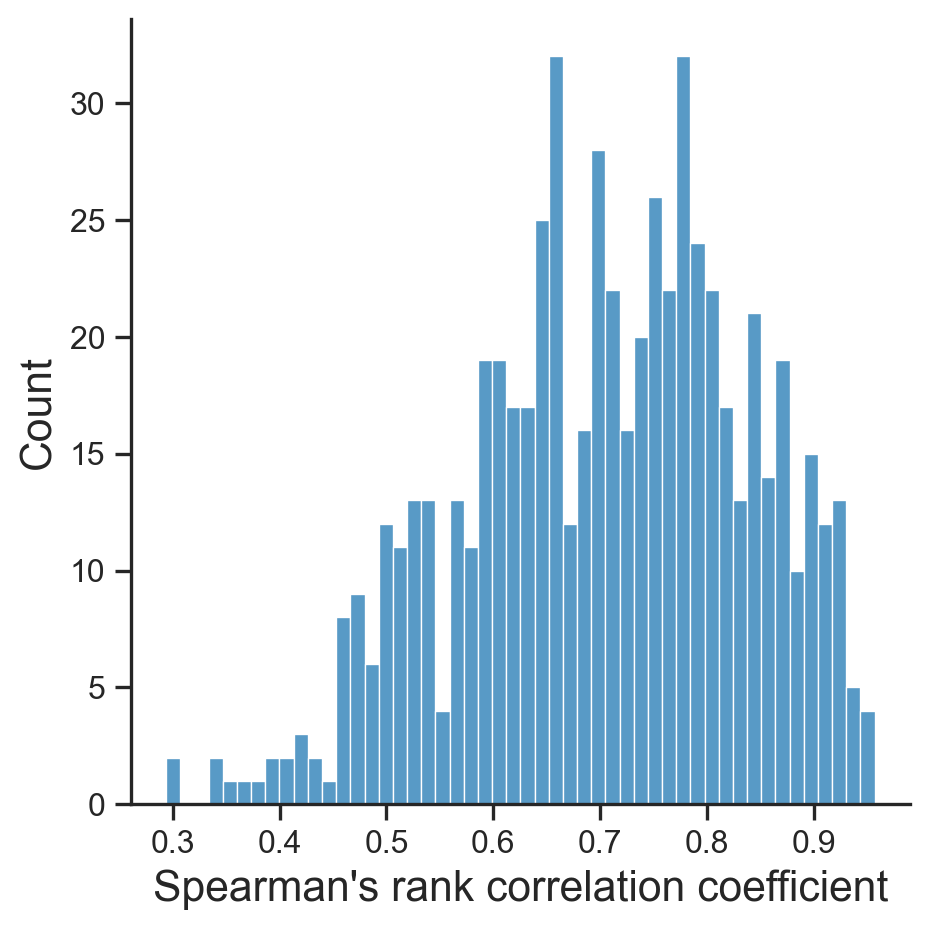

In [ ]:
(
    df_paralogBootstrapResult.query("p < 0.05").pipe(so.Plot, x='SpearmanR')
    .add(so.Bars(color='#116FAF'), so.Hist(bins=50))
    .theme({**dt_snsStyle, 'axes.labelsize': 16, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
    .label(x = "Spearman's rank correlation coefficient", y = "Count")
    .layout(size=(5,5))
)

In [ ]:
ad.uns['gene_dup_corr'] = df_paralogBootstrapResult

# diff

In [ ]:
_lsDf = []
for cluster in ad_merged.obs['Cluster'].unique():
    _df = df_paralog1v1Only[['G1', 'G2', 'Gene Shuffle']]
    _df['G1_expression'] = ad_merged.to_df('normalize_log').loc[cluster, _df['G1']].values
    _df['G2_expression'] = ad_merged.to_df('normalize_log').loc[cluster, _df['G2']].values
    _df['Shuffle_expression'] = ad_merged.to_df('normalize_log').loc[cluster, _df['Gene Shuffle']].values
    _df['Cluster'] = cluster

    _lsDf.append(_df)

In [ ]:
df_1v1OnlyDiff = pd.concat(_lsDf)

In [ ]:
df_1v1OnlyDiff = (
    df_1v1OnlyDiff
    .eval("Diff = G1_expression - G2_expression \n Shuffle_Diff = G1_expression - Shuffle_expression", engine='python')
    .eval("Diff = Diff.abs() \n Shuffle_Diff = Shuffle_Diff.abs()", engine='python')
    .assign(Diff = lambda df:np.exp(df['Diff']), Shuffle_Diff = lambda df:np.exp(df['Shuffle_Diff']))
    .rename(columns={'Diff':'Diff Fc', 'Shuffle_Diff':'Shuffle Fc'})
    .assign(Diff = lambda df:np.abs(np.exp(df['G1_expression']) - np.exp(df['G2_expression'])), Shuffle_Diff =  lambda df:np.abs(np.exp(df['G1_expression']) - np.exp(df['Shuffle_expression'])))
)

In [ ]:
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the withs of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])

In [ ]:
from itertools import cycle
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

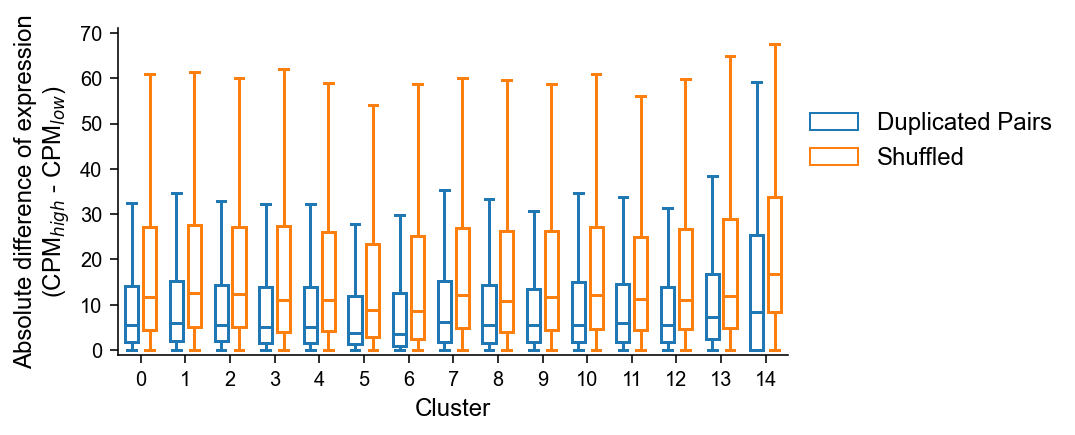

In [ ]:
fig, ax = plt.subplots(figsize=(6,3))
df_1v1OnlyDiff.melt("Cluster", ['Diff', 'Shuffle_Diff'], 'Group', 'Diff').pipe(sns.boxplot, x='Cluster', y='Diff', hue='Group', fliersize=0, ax=ax, )
plt.ylim(-1, 71)

for i, (box, color) in enumerate(zip([x for x in ax.get_children() if isinstance(x, mpl.patches.PathPatch)], cycle(sns.color_palette()[:2]))):
    box.set_edgecolor(color)
    box.set_facecolor("white")
    # iterate over whiskers and median lines
    for j in range(6 * i, 6 * (i + 1)):
        ax.lines[j].set_color(color)

legend_elements = [Patch(facecolor='white', edgecolor=sns.color_palette()[0],
                         label='Duplicated Pairs'), Patch(facecolor='white', edgecolor=sns.color_palette()[1],
                         label='Shuffled')]

plt.legend(handles=legend_elements, loc='lower left', bbox_to_anchor=(1, 0.5), frameon=False, fontsize=12)
plt.ylabel('Absolute difference of expression\n(CPM$_{high}$ - CPM$_{low}$)', fontsize=12)
plt.xlabel("Cluster", fontsize=12)
adjust_box_widths(fig, 0.75)
sns.despine()

In [ ]:
ad.uns['gene_dup_diff'] = df_1v1OnlyDiff

In [ ]:
del(ad.var['bins_ForPickMock'])

In [ ]:
del(ad.obsm['seurat_integrated_data'])

In [ ]:
toPkl(ad, 'ad_gene_dup', 'ipf', dir_path=dir_result)

2022-11-01 20:15:36.728 | INFO     | jpy_tools.otherTools:toPkl:477 - please run `loadPkl('ad_gene_dup', lambda **dt:sc.read_h5ad(**dt), arg_path='filename')` to get object


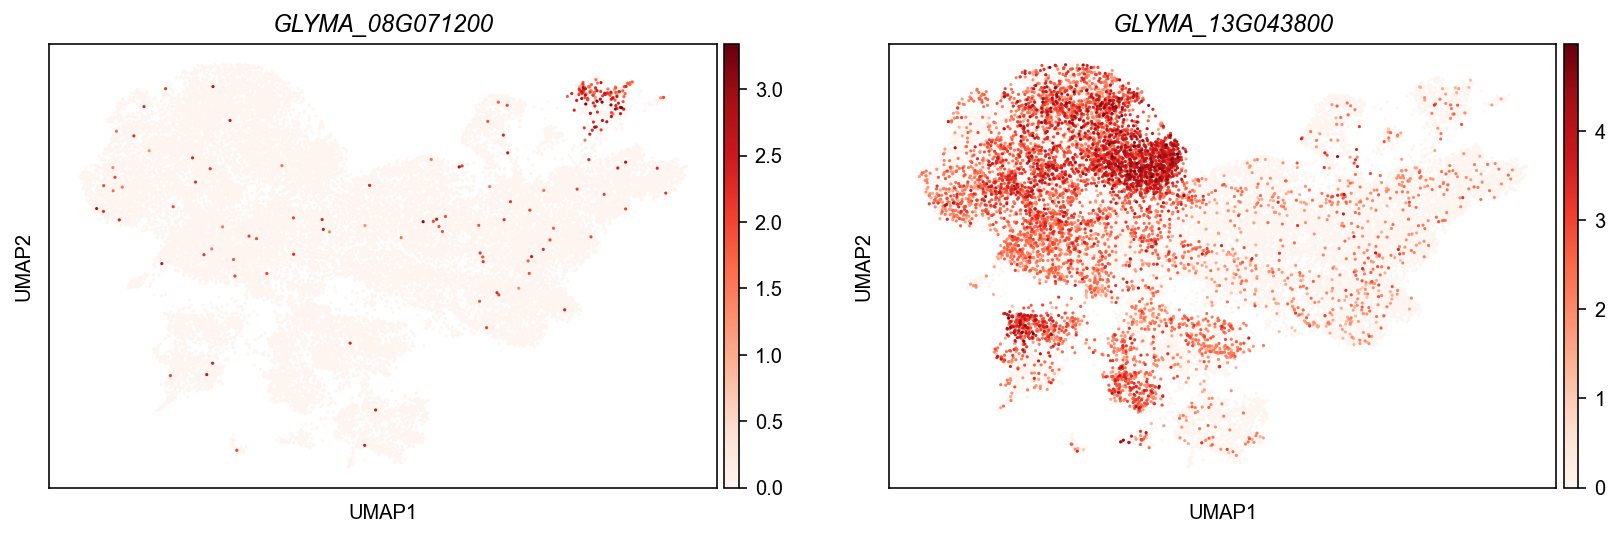

In [ ]:
axs = sc.pl.umap(ad, color=['GLYMA_08G071200', 'GLYMA_13G043800'], layer='normalize_log', cmap='Reds', show=False, size=10)
for ax in axs:
    plt.sca(ax)
    plt.title(ax.get_title(), fontstyle='italic')

In [ ]:
df_1v1OnlyDiff.groupby('Cluster').apply(lambda df:scipy.stats.ttest_ind(df['Diff'], df['Shuffle_Diff']).pvalue)

Cluster
0     1.463250e-04
1     1.085058e-07
10    2.282406e-16
11    2.502472e-03
12    3.519299e-05
13    3.588771e-13
14    1.731463e-13
2     3.281360e-10
3     3.579497e-32
4     2.973648e-13
5     1.416890e-10
6     3.381553e-09
7     2.221386e-07
8     4.559358e-16
9     2.118819e-14
dtype: float64